In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### Dataloader and Window(20 sec, 2 sec Overlap)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# STEP 0: Load data
df_feat = pd.read_csv("ml_processed/df_feat.csv")

# # STEP 1: Remove last 30s windows
# sampling_rate = 120
# window_stride = 240  # 2s
# windows_per_30s = int(30 * sampling_rate / window_stride)

# def remove_last_windows(df, group_col="participant", n_remove=15):
#     return df.groupby(group_col, group_keys=False).apply(
#         lambda g: g.iloc[:-n_remove] if len(g) > n_remove else g.iloc[0:0]
#     )

# df_feat = remove_last_windows(df_feat, n_remove=windows_per_30s)


In [2]:
df_feat

participant  start_idx   anxiety  EDA_Tonic_mean  EDA_Tonic_std  \
0                1          0 -0.582982        0.550093       0.938335   
1                1        240 -0.819513        0.695566       0.704165   
2                1        480 -1.030404        0.731956       0.632326   
3                1        720 -1.149504        0.650131       0.749712   
4                1        960 -1.165964        0.462547       0.906106   
...            ...        ...       ...             ...            ...   
17341          108      25440 -0.506723      -30.000000       0.000000   
17342          108      25680 -0.931963      -30.000000       0.000000   
17343          108      25920 -1.356883      -30.000000       0.000000   
17344          108      26160 -1.727105      -30.000000       0.000000   
17345          108      26400 -1.945233      -30.000000       0.000000   

       EDA_Tonic_max  EDA_Tonic_slope  EDA_Phasic_mean  EDA_Phasic_std  \
0           1.505017     9.111264e-04         0.035771        0.737004   
1           1.505017     2.485187e-04         0.127195        0.650272   
2           1.505017    -3.884715e-04         0.227756        0.489198   
3           1.505017    -9.021320e-04         0.159699        0.420645   
4           1.505017    -1.253904e-03         0.069397        0.258321   
...              ...              ...              ...             ...   
17341     -30.000000    -1.790124e-18         0.275528        0.135562   
17342     -30.000000    -1.790124e-18         0.281274        0.136841   
17343     -30.000000    -1.790124e-18         0.288368        0.137415   
17344     -30.000000    -1.790124e-18         0.300028        0.136786   
17345     -30.000000    -1.790124e-18         0.309633        0.134676   

       EDA_Phasic_max  ...  pupilR_std  pupilR_max  pupilR_slope  \
0            1.499846  ...    0.981270    0.846837      0.000029   
1            1.499846  ...    1.013622    0.928966      0.000287   
2            1.499846  ...    1.023465    0.928966      0.000430   
3            1.499846  ...    1.045251    0.928966      0.000513   
4            0.666747  ...    0.932476    1.030204      0.000428   
...               ...  ...         ...         ...           ...   
17341        0.563566  ...    0.914851    1.220770      0.000234   
17342        0.563566  ...    0.756456    1.220770      0.000012   
17343        0.563566  ...    0.692460    1.220770      0.000008   
17344        0.563566  ...    0.634422    1.220770     -0.000042   
17345        0.563566  ...    0.636714    1.220770     -0.000033   

       pupil_mean_mean  pupil_mean_std  pupil_mean_max  pupil_mean_slope  \
0            -0.018643        0.981378        0.838556          0.000027   
1            -0.021812        1.017374        0.908665          0.000285   
2            -0.007330        1.027270        0.908665          0.000427   
3             0.067427        1.048357        0.921751          0.000506   
4             0.195558        0.943593        1.029005          0.000432   
...                ...             ...             ...               ...   
17341        -0.115367        0.910929        0.568632          0.000250   
17342        -0.020273        0.756121        0.568632          0.000044   
17343         0.017732        0.688683        0.568632          0.000018   
17344         0.048292        0.628716        0.568632         -0.000004   
17345         0.055062        0.630939        0.568632          0.000037   

        HRV_RMSSD    HRV_SDNN  HRV_pNN50  
0      323.929862  241.831436  68.181818  
1      344.268548  255.976835  71.428571  
2      345.557119  263.738261  71.428571  
3      382.904031  270.115784  80.000000  
4      371.203984  265.094047  80.000000  
...           ...         ...        ...  
17341   21.930962   29.076770   0.000000  
17342   20.030840   30.386739   0.000000  
17343   21.872244   31.791675   0.000000  
17344   20.848760   31.280482   0.000000  
17345   22.737091   31.314

In [7]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------------------------------------------
# ✅ 설정
# ---------------------------------------------
window_seconds = 30
stride_seconds = 2
sampling_rate = 120
gap_seconds = 30
gap = int(gap_seconds / stride_seconds)  # window 단위로 변환

seed = 42
random.seed(seed)
np.random.seed(seed)

# ---------------------------------------------
# ✅ 모델 설정
# ---------------------------------------------
model_class = RandomForestRegressor
model_init_args = {"random_state": seed, "n_jobs": -1}
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 10]
}

# ---------------------------------------------
# ✅ 데이터 분할 (participant 기준 10% test)
# ---------------------------------------------
all_pids = df_feat["participant"].unique()
test_pids = np.random.choice(all_pids, size=int(len(all_pids) * 0.1), replace=False)
trainval_pids = [p for p in all_pids if p not in test_pids]

df_test_all = df_feat[df_feat["participant"].isin(test_pids)].copy().sort_values(["participant", "start_idx"])
df_trainval_all = df_feat[df_feat["participant"].isin(trainval_pids)].copy()

# ---------------------------------------------
# ✅ STEP 1: Feature Selection (GroupKFold)
# ---------------------------------------------
X_trainval = df_trainval_all.drop(columns=["participant", "start_idx", "anxiety"])
y_trainval = df_trainval_all["anxiety"]
groups = df_trainval_all["participant"]

rfecv = RFECV(
    estimator=model_class(**model_init_args),
    step=3,
    cv=GroupKFold(n_splits=3),
    scoring='r2',
    min_features_to_select=10,
    n_jobs=-1
)
rfecv.fit(X_trainval, y_trainval, groups=groups)
selected_features = X_trainval.columns[rfecv.support_]
print(f"📌 선택된 feature 수: {len(selected_features)} / {X_trainval.shape[1]}")

# ---------------------------------------------
# ✅ STEP 2: Hyperparameter Tuning (validation by PID)
# ---------------------------------------------
val_pid_count = max(1, int(0.1 * len(trainval_pids)))
val_pids = np.random.choice(trainval_pids, size=val_pid_count, replace=False)
train_pids = [p for p in trainval_pids if p not in val_pids]

df_train = df_trainval_all[df_trainval_all["participant"].isin(train_pids)].copy()
df_val = df_trainval_all[df_trainval_all["participant"].isin(val_pids)].copy()

X_train = df_train[selected_features]
y_train = df_train["anxiety"]
X_val = df_val[selected_features]
y_val = df_val["anxiety"]

# ✅ Hyperparam Tuning (validation by PID)
grid = GridSearchCV(
    model_class(**model_init_args),
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    return_train_score=True
)

# ✅ FIX: training set으로 학습
grid.fit(X_train, y_train)

# ✅ 추가: 결과 로깅
cv_results_df = pd.DataFrame(grid.cv_results_)
cv_results_df = cv_results_df.sort_values(by="mean_test_score", ascending=False)
print("\n📊 Grid Search Results (Top 5):")
print(cv_results_df[["params", "mean_test_score", "std_test_score"]].head())

# ---------------------------------------------
# ✅ STEP 3~5: Finetune / Test split (전체 1회 수행)
# ---------------------------------------------
df_test_all = df_test_all.sort_values(["participant", "start_idx"]).reset_index(drop=True)
split_idx = int(len(df_test_all) * 0.5)

df_finetune = df_test_all.iloc[:split_idx]
df_test     = df_test_all.iloc[split_idx + gap:]

X_finetune = df_finetune[selected_features]
y_finetune = df_finetune["anxiety"]
X_test     = df_test[selected_features]
y_test     = df_test["anxiety"]

print(f"   🔹 Finetune: {len(df_finetune)} | Test: {len(df_test)}")

# Fine-tuned model
model_ft = model_class(**grid.best_params_)
model_ft.fit(pd.concat([X_train, X_finetune]), pd.concat([y_train, y_finetune]))
y_pred = model_ft.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Baseline (only train)
model_base = model_class(**grid.best_params_)
model_base.fit(X_train, y_train)
y_pred_base = model_base.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)

# Drift 계산
drift = df_finetune["anxiety"].mean() - df_test["anxiety"].mean()

# 채택 여부
if r2 > r2_base:
    method = "finetuned"
    r2_final, rmse_final, mae_final = r2, rmse, mae
else:
    method = "baseline"
    r2_final, rmse_final, mae_final = r2_base, rmse_base, mae_base

# ---------------------------------------------
# ✅ 결과 요약
# ---------------------------------------------
print("\n📊 Final Evaluation (10% Test Participants):")
print(f"   [Finetuned] R²: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
print(f"   [Baseline ] R²: {r2_base:.4f} | RMSE: {rmse_base:.4f} | MAE: {mae_base:.4f}")
print(f"   👉 채택: {method.upper()} | Δ mean(anxiety): {drift:.4f}")


📌 선택된 feature 수: 29 / 47

📊 Grid Search Results (Top 5):
                                   params  mean_test_score  std_test_score
1   {'max_depth': 3, 'n_estimators': 200}        -0.228243        0.108888
0   {'max_depth': 3, 'n_estimators': 100}        -0.235019        0.111970
2   {'max_depth': 5, 'n_estimators': 100}        -0.241300        0.111075
3   {'max_depth': 5, 'n_estimators': 200}        -0.243316        0.113272
4  {'max_depth': 10, 'n_estimators': 100}        -0.266170        0.135992
   🔹 Finetune: 842 | Test: 827

📊 Final Evaluation (10% Test Participants):
   [Finetuned] R²: -4.0439 | RMSE: 2.5174 | MAE: 1.6384
   [Baseline ] R²: -4.3463 | RMSE: 2.5918 | MAE: 1.6210
   👉 채택: FINETUNED | Δ mean(anxiety): 1.5132


In [11]:
import pandas as pd
import numpy as np
import random
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------------------------------------------
# ✅ 설정
# ---------------------------------------------
window_seconds = 30
stride_seconds = 2
sampling_rate = 120
gap_seconds = 30
gap = int(gap_seconds / stride_seconds)

seed = 42
random.seed(seed)
np.random.seed(seed)

# ---------------------------------------------
# ✅ 모델 설정 (CatBoost)
# ---------------------------------------------
model_class = CatBoostRegressor
model_init_args = {
    "random_state": seed,
    "thread_count": -1,
    "verbose": False
}
param_grid = {
    "depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05],
    "iterations": [100, 200]
}

# ---------------------------------------------
# ✅ 데이터 분할 (participant 기준 10% test)
# ---------------------------------------------
all_pids = df_feat["participant"].unique()
test_pids = np.random.choice(all_pids, size=int(len(all_pids) * 0.1), replace=False)
trainval_pids = [p for p in all_pids if p not in test_pids]

df_test_all = df_feat[df_feat["participant"].isin(test_pids)].copy().sort_values(["participant", "start_idx"])
df_trainval_all = df_feat[df_feat["participant"].isin(trainval_pids)].copy()

# ---------------------------------------------
# ✅ STEP 1: Feature Selection (GroupKFold)
# ---------------------------------------------
X_trainval = df_trainval_all.drop(columns=["participant", "start_idx", "anxiety"])
y_trainval = df_trainval_all["anxiety"]
groups = df_trainval_all["participant"]

rfecv = RFECV(
    estimator=model_class(**model_init_args),
    step=3,
    cv=GroupKFold(n_splits=3),
    scoring='r2',
    min_features_to_select=10,
    n_jobs=1
)
rfecv.fit(X_trainval, y_trainval, groups=groups)
selected_features = X_trainval.columns[rfecv.support_]
print(f"📌 선택된 feature 수: {len(selected_features)} / {X_trainval.shape[1]}")

# ---------------------------------------------
# ✅ STEP 2: Hyperparameter Tuning (validation by PID)
# ---------------------------------------------
val_pid_count = max(1, int(0.1 * len(trainval_pids)))
val_pids = np.random.choice(trainval_pids, size=val_pid_count, replace=False)
train_pids = [p for p in trainval_pids if p not in val_pids]

df_train = df_trainval_all[df_trainval_all["participant"].isin(train_pids)].copy()
df_val = df_trainval_all[df_trainval_all["participant"].isin(val_pids)].copy()

X_train = df_train[selected_features]
y_train = df_train["anxiety"]
X_val = df_val[selected_features]
y_val = df_val["anxiety"]

grid = GridSearchCV(
    model_class(**model_init_args),
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_train, y_train)

cv_results_df = pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_score", ascending=False)
print("\n📊 Grid Search Results (Top 5):")
print(cv_results_df[["params", "mean_test_score", "std_test_score"]].head())

# ---------------------------------------------
# ✅ STEP 3~5: Finetune / Test split (전체 1회 수행)
# ---------------------------------------------
df_test_all = df_test_all.sort_values(["participant", "start_idx"]).reset_index(drop=True)
split_idx = int(len(df_test_all) * 0.5)

df_finetune = df_test_all.iloc[:split_idx]
df_test     = df_test_all.iloc[split_idx + gap:]

X_finetune = df_finetune[selected_features]
y_finetune = df_finetune["anxiety"]
X_test     = df_test[selected_features]
y_test     = df_test["anxiety"]

print(f"   🔹 Finetune: {len(df_finetune)} | Test: {len(df_test)}")

# Fine-tuned model
model_ft = model_class(**grid.best_params_, **model_init_args)
model_ft.fit(pd.concat([X_train, X_finetune]), pd.concat([y_train, y_finetune]))
y_pred = model_ft.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Baseline (only train)
model_base = model_class(**grid.best_params_, **model_init_args)
model_base.fit(X_train, y_train)
y_pred_base = model_base.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)

# Drift 계산
drift = df_finetune["anxiety"].mean() - df_test["anxiety"].mean()

if r2 > r2_base:
    method = "finetuned"
    r2_final, rmse_final, mae_final = r2, rmse, mae
else:
    method = "baseline"
    r2_final, rmse_final, mae_final = r2_base, rmse_base, mae_base

# ---------------------------------------------
# ✅ 결과 요약
# ---------------------------------------------
print("\n📊 Final Evaluation (10% Test Participants):")
print(f"   [Finetuned] R²: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
print(f"   [Baseline ] R²: {r2_base:.4f} | RMSE: {rmse_base:.4f} | MAE: {mae_base:.4f}")
print(f"   👉 채택: {method.upper()} | Δ mean(anxiety): {drift:.4f}")


📌 선택된 feature 수: 17 / 47

📊 Grid Search Results (Top 5):
                                               params  mean_test_score  \
8   {'depth': 7, 'iterations': 100, 'learning_rate...        -0.148399   
10  {'depth': 7, 'iterations': 200, 'learning_rate...        -0.153395   
4   {'depth': 5, 'iterations': 100, 'learning_rate...        -0.154685   
6   {'depth': 5, 'iterations': 200, 'learning_rate...        -0.166954   
0   {'depth': 3, 'iterations': 100, 'learning_rate...        -0.174953   

    std_test_score  
8         0.111043  
10        0.097142  
4         0.113036  
6         0.093479  
0         0.117834  
   🔹 Finetune: 842 | Test: 827

📊 Final Evaluation (10% Test Participants):
   [Finetuned] R²: -0.2403 | RMSE: 1.2484 | MAE: 0.9778
   [Baseline ] R²: -0.2274 | RMSE: 1.2418 | MAE: 0.9665
   👉 채택: BASELINE | Δ mean(anxiety): 1.5132


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_absolute_error

# ---------------------------------------------
# ✅ 모델 스펙 설정
# ---------------------------------------------
model_class = RandomForestRegressor
model_init_args = {"random_state": 42}
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 10]
}
rfecv_estimator = model_class(**model_init_args)

# ---------------------------------------------
# ✅ LOPO with fine-tune condition + drift logging
# ---------------------------------------------
participants = df_feat["participant"].unique()
results = []

for target_pid in participants:
    print(f"\n🧪 PID {target_pid} → LOPO 진행 중")

    # STEP 1. Train/Target split
    df_train = df_feat[df_feat["participant"] != target_pid].copy()
    df_target = df_feat[df_feat["participant"] == target_pid].copy()

    # STEP 2. Feature/Target 분리
    X_train_full = df_train.drop(columns=["participant", "start_idx", "anxiety"])
    y_train_full = df_train["anxiety"]
    X_target_full = df_target.drop(columns=["participant", "start_idx", "anxiety"])
    y_target_full = df_target["anxiety"]

    # STEP 3. Feature Selection (RFECV)
    print("🔍 Feature Selection 진행 중...")
    rfecv = RFECV(
        estimator=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        step=5,
        cv=3,
        scoring='r2',
        min_features_to_select=10,
        n_jobs=-1
    )
    rfecv.fit(X_train_full, y_train_full)
    selected_features = X_train_full.columns[rfecv.support_]
    print(f"📌 선택된 feature 수: {len(selected_features)} / {len(X_train_full.columns)}")

    X_train_sel = X_train_full[selected_features]
    X_target_sel = X_target_full[selected_features]

    # STEP 4. Hyperparameter Tuning
    print("🔍 Hyperparam Selection 진행 중...")
    grid = GridSearchCV(model_class(**model_init_args), param_grid, cv=3, scoring="r2", n_jobs=-1)
    grid.fit(X_train_sel, y_train_full)
    best_model = grid.best_estimator_
    print(f"📌 최적의 하이퍼파라미터: {grid.best_params_}")

    # STEP 5. Target split with gap
    df_target = df_target.sort_values("start_idx").reset_index(drop=True)
    split_idx = int(len(df_target) * 0.5)
    gap = 10
    df_finetune = df_target.iloc[:split_idx]
    df_test     = df_target.iloc[split_idx + gap:]

    X_finetune = df_finetune[selected_features]
    y_finetune = df_finetune["anxiety"]
    X_test     = df_test[selected_features]
    y_test     = df_test["anxiety"]

    print(f"   🔹 Finetune windows: {len(df_finetune)} | Test windows: {len(df_test)}")

    # STEP 6A. Finetune model
    best_model.fit(pd.concat([X_train_sel, X_finetune]), pd.concat([y_train_full, y_finetune]))
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    mae = mean_absolute_error(y_test, y_pred)

    # STEP 6B. Baseline model
    baseline_model = model_class(**grid.best_params_)
    baseline_model.fit(X_train_sel, y_train_full)
    y_pred_base = baseline_model.predict(X_test)
    r2_base = r2_score(y_test, y_pred_base)
    rmse_base = np.sqrt(np.mean((y_test - y_pred_base) ** 2))
    mae_base = mean_absolute_error(y_test, y_pred_base)

    # STEP 7. Drift 측정
    mean_ft = df_finetune["anxiety"].mean()
    mean_te = df_test["anxiety"].mean()
    mean_diff = mean_ft - mean_te

    # STEP 8. Fine-tune 채택 여부 결정
    if r2 > r2_base:
        r2_final = r2
        rmse_final = rmse
        mae_final = mae
        method = "finetuned"
    else:
        r2_final = r2_base
        rmse_final = rmse_base
        mae_final = mae_base
        method = "baseline"

    # 저장
    results.append({
        "participant": target_pid,
        "r2": r2,
        "rmse": rmse,
        "mae": mae,
        "r2_base": r2_base,
        "rmse_base": rmse_base,
        "mae_base": mae_base,
        "r2_final": r2_final,
        "rmse_final": rmse_final,
        "mae_final": mae_final,
        "method": method,
        "mean_diff": mean_diff
    })

    print(f"📊 PID {target_pid} 결과 요약")
    print(f"   [Fine-tuned] R²: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    print(f"   [Baseline  ] R²: {r2_base:.4f} | RMSE: {rmse_base:.4f} | MAE: {mae_base:.4f}")
    print(f"   👉 채택된 모델: {method.upper()} | Δ mean(anxiety): {mean_diff:.4f}")

# STEP 9: 전체 결과 저장
results_df = pd.DataFrame(results)
print("\n✅ 전체 결과 요약:")
print(results_df.describe())



🧪 PID 1 → LOPO 진행 중
🔍 Feature Selection 진행 중...
📌 선택된 feature 수: 42 / 47
🔍 Hyperparam Selection 진행 중...
📌 최적의 하이퍼파라미터: {'max_depth': 3, 'n_estimators': 200}
   🔹 Finetune windows: 89 | Test windows: 79
📊 PID 1 결과 요약
   [Fine-tuned] R²: -0.3026 | RMSE: 1.9198 | MAE: 1.6906
   [Baseline  ] R²: -0.4790 | RMSE: 2.0456 | MAE: 1.8035
   👉 채택된 모델: FINETUNED | Δ mean(anxiety): -1.7422

🧪 PID 2 → LOPO 진행 중
🔍 Feature Selection 진행 중...
📌 선택된 feature 수: 37 / 47
🔍 Hyperparam Selection 진행 중...
📌 최적의 하이퍼파라미터: {'max_depth': 3, 'n_estimators': 100}
   🔹 Finetune windows: 66 | Test windows: 57
📊 PID 2 결과 요약
   [Fine-tuned] R²: 0.2065 | RMSE: 0.9657 | MAE: 0.7479
   [Baseline  ] R²: 0.1930 | RMSE: 0.9739 | MAE: 0.7736
   👉 채택된 모델: FINETUNED | Δ mean(anxiety): -0.5482

🧪 PID 3 → LOPO 진행 중
🔍 Feature Selection 진행 중...
📌 선택된 feature 수: 32 / 47
🔍 Hyperparam Selection 진행 중...
📌 최적의 하이퍼파라미터: {'max_depth': 3, 'n_estimators': 100}
   🔹 Finetune windows: 58 | Test windows: 49
📊 PID 3 결과 요약
   [Fine-tuned] R²: -4.

In [15]:
from collections import defaultdict

drift_records = []

for target_pid in df_feat["participant"].unique():
    df_target = df_feat[df_feat["participant"] == target_pid].sort_values("start_idx").reset_index(drop=True)
    split_idx = int(len(df_target) * 0.7)
    gap = 10

    df_finetune = df_target.iloc[:split_idx]
    df_test = df_target.iloc[split_idx + gap:]

    if len(df_finetune) < 5 or len(df_test) < 5:
        continue  # 데이터 너무 적은 경우 제외

    mean_ft = df_finetune["anxiety"].mean()
    mean_te = df_test["anxiety"].mean()
    diff = mean_ft - mean_te

    drift_records.append({
        "participant": target_pid,
        "mean_finetune": mean_ft,
        "mean_test": mean_te,
        "mean_diff": diff
    })

drift_df = pd.DataFrame(drift_records)


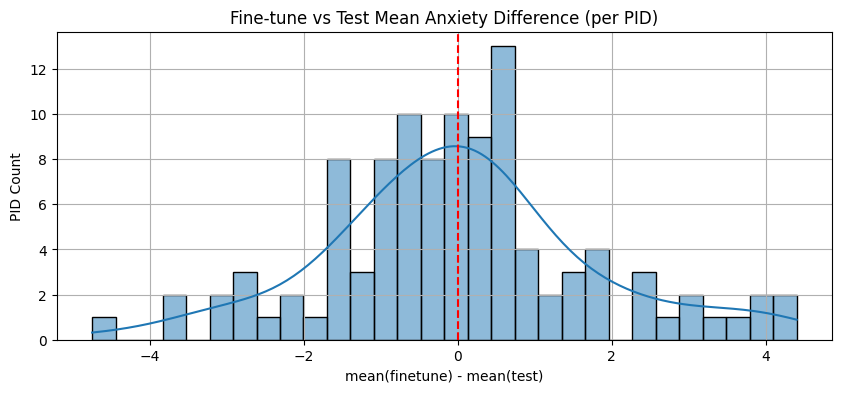

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(drift_df["mean_diff"], bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Fine-tune vs Test Mean Anxiety Difference (per PID)")
plt.xlabel("mean(finetune) - mean(test)")
plt.ylabel("PID Count")
plt.grid()
plt.show()


### Feature Selection

In [3]:

# Step 0️⃣: 예시 participant로부터 column 구조만 추출
sample_name = participant_list[0]
sample_df = pd.read_pickle(os.path.join(base_path, f"{sample_name}_Main.pkl"))
sample_df = sample_df[sample_df['scene'] == 'Outside'].copy()
sample_df.reset_index(drop=True, inplace=True)

exclude_keywords = [
    'unit',       # face tracker
    'Frame',      # 단순 index
    'X_pos', 'Y_pos', 'Z_pos',     # 위치 좌표
    'X_rot', 'Y_rot', 'Z_rot',     # 회전값
    'validL', 'validR',            # 눈 추적 유효 여부 (bool성태 숫자)
    'gazeorigin', 'gazeL_', 'gazeR_',  # 시선 방향 좌표
    'pupilLSensorPos',             # 동공 센서 위치
     'eye_openness'
]
feature_cols = [
    col for col in sample_df.columns
    if (
        col not in ['anxiety', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        sample_df[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

Generating Windows:   0%|          | 0/108 [00:00<?, ?it/s]

Generating Windows: 100%|██████████| 108/108 [00:11<00:00,  9.43it/s]


✅ 최종 window 수: 2300
🚫 NaN 때문에 제외된 window 수: 56


participant  start_idx                note
0         064          0  All NaN in anxiety
1         064       1800  All NaN in anxiety
2         064       3600  All NaN in anxiety
3         064       5400  All NaN in anxiety
4         064       7200  All NaN in anxiety

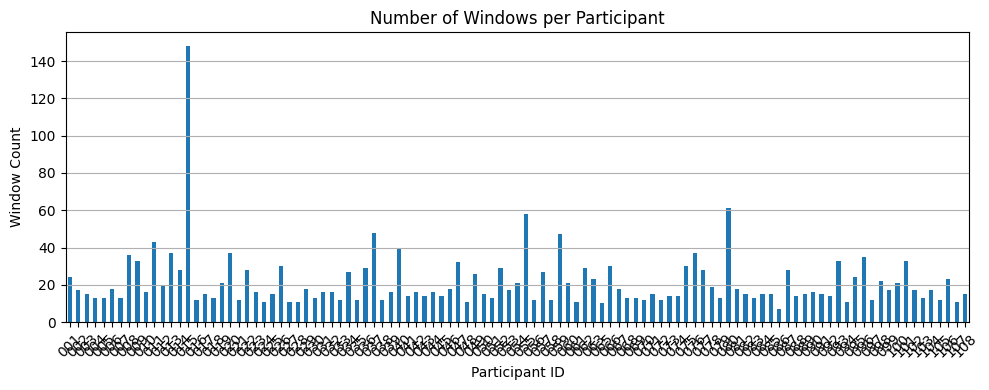

In [4]:
windowed_data = []
nan_log = []  # NaN 로그 저장
for name, df in tqdm(data_dict.items(), desc="Generating Windows"):
    df = df.reset_index(drop=True)
    for start in range(0, len(df) - window_size + 1, stride_size):
        end = start + window_size
        window_df = df.iloc[start:end]

        anxiety_values = window_df["anxiety"]
        anxiety_mean = anxiety_values.mean()

        # NaN인지 먼저 확인
        if np.isnan(anxiety_mean):
            nan_log.append({
                "participant": name,
                "start_idx": start,
                "note": "All NaN in anxiety"
            })
            continue  # 이 window는 skip

        features = {}
        for col in feature_cols:
            features[f"{col}_mean"] = window_df[col].mean()
            features[f"{col}_std"] = window_df[col].std()

        features["anxiety_mean"] = anxiety_mean
        features["participant"] = name
        features["start_idx"] = start
        windowed_data.append(features)

# 결과 저장
window_df_all = pd.DataFrame(windowed_data)
nan_log_df = pd.DataFrame(nan_log)

print(f"\n✅ 최종 window 수: {len(window_df_all)}")
print(f"🚫 NaN 때문에 제외된 window 수: {len(nan_log_df)}")

# 필요 시 확인
display(nan_log_df.head())


# Step 4️⃣: 참가자별 window 수 시각화
participant_counts = window_df_all['participant'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
participant_counts.plot(kind='bar')
plt.title("Number of Windows per Participant")
plt.xlabel("Participant ID")
plt.ylabel("Window Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [5]:
# 🔹 1. feature column 목록 정리 (불필요한 열 제거)
feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety_mean', 'participant', 'start_idx']
]

# 🔹 2. 상관관계 행렬 계산 (절댓값 기준)
corr_matrix = window_df_all[feature_cols].corr().abs()

# 🔹 3. 상삼각행렬로 중복 제거
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 🔹 4. 상관계수 0.95 초과하는 column 목록 수집
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# 🔹 5. 필터링된 feature 목록
filtered_features = [col for col in feature_cols if col not in to_drop]

print(f"💡 제거된 중복 feature 수: {len(to_drop)}")
print(f"✅ 최종 feature 수: {len(filtered_features)}")
# feature_cols = filtered_features

💡 제거된 중복 feature 수: 21
✅ 최종 feature 수: 37


In [6]:
window_df_all = window_df_all[window_df_all["participant"] != "nsk9105"].reset_index(drop=True)

print(f"🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: {len(window_df_all)}")

🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: 2300


In [7]:
len(window_df_all['participant'].unique())  # 참가자 목록 확인

107

In [8]:
import os
import shutil

# 경로 설정
source_dir = 'D:/LabRoom/Projects/SD Physiology/Processed/processed_individual_anonymized'
target_dir = 'D:/LabRoom/Projects/SD Physiology/Main_pkl_only'
os.makedirs(target_dir, exist_ok=True)

# 파일 복사
for filename in os.listdir(source_dir):
    if filename.endswith('_Main.pkl'):
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(target_dir, filename)
        shutil.copy2(src_path, dst_path)

print("✅ All _Main.pkl files copied.")


✅ All _Main.pkl files copied.


In [9]:
# 참가자별 window 개수 집계
participant_counts = window_df_all['participant'].value_counts()

# 5개 미만인 참가자만 추출
too_short = participant_counts[participant_counts < 5]

# 결과 출력
print(f"🚫 너무 짧은 참가자 수 (<5 windows): {len(too_short)}명")
display(too_short)

🚫 너무 짧은 참가자 수 (<5 windows): 0명


Series([], Name: count, dtype: int64)

In [10]:
window_df_all.columns

Index(['pupilL_mean', 'pupilL_std', 'pupilR_mean', 'pupilR_std',
       'PPG_Raw_mean', 'PPG_Raw_std', 'PPG_Clean_mean', 'PPG_Clean_std',
       'PPG_Rate_mean', 'PPG_Rate_std', 'PPG_Quality_mean', 'PPG_Quality_std',
       'PPG_Peaks_mean', 'PPG_Peaks_std', 'EDA_Raw_mean', 'EDA_Raw_std',
       'EDA_Clean_mean', 'EDA_Clean_std', 'EDA_Tonic_mean', 'EDA_Tonic_std',
       'EDA_Phasic_mean', 'EDA_Phasic_std', 'SCR_Onsets_mean',
       'SCR_Onsets_std', 'SCR_Peaks_mean', 'SCR_Peaks_std', 'SCR_Height_mean',
       'SCR_Height_std', 'SCR_Amplitude_mean', 'SCR_Amplitude_std',
       'SCR_RiseTime_mean', 'SCR_RiseTime_std', 'SCR_Recovery_mean',
       'SCR_Recovery_std', 'SCR_RecoveryTime_mean', 'SCR_RecoveryTime_std',
       'RSP_Raw_mean', 'RSP_Raw_std', 'RSP_Clean_mean', 'RSP_Clean_std',
       'RSP_Amplitude_mean', 'RSP_Amplitude_std', 'RSP_Rate_mean',
       'RSP_Rate_std', 'RSP_RVT_mean', 'RSP_RVT_std', 'RSP_Phase_mean',
       'RSP_Phase_std', 'RSP_Phase_Completion_mean',
       'RSP_P

### Run

MAE: 1.465, RMSE: 1.853, R²: 0.486


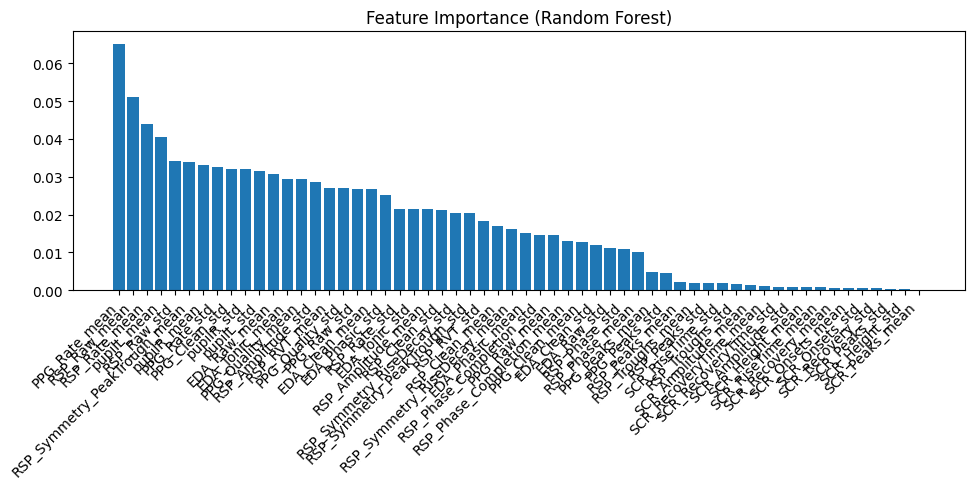

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 🎯 1. Feature 선택
feature_cols = [col for col in window_df_all.columns 
                if (col.endswith('_mean') or col.endswith('_std')) 
                and col != "anxiety_mean"]

# 🧼 2. NaN 제거된 상태의 데이터 재분할 (participant 단위 split 생략하고 전체 랜덤 split 예시)
from sklearn.model_selection import train_test_split
X = window_df_all[feature_cols]
y = window_df_all["anxiety_mean"]

# (선택) Feature scaling (RandomForest는 필요 없음, 다른 모델 대비용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🌳 3. 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 🧪 4. 예측 및 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 📊 5. Feature Importance 시각화
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [feature_cols[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(range(len(top_features)), importances[indices])
plt.xticks(range(len(top_features)), top_features, rotation=45, ha='right')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_88340\153185954.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20], palette="Blues_d")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_88340\153185954.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20], palette="Blues_d")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_88340\153185954.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20],

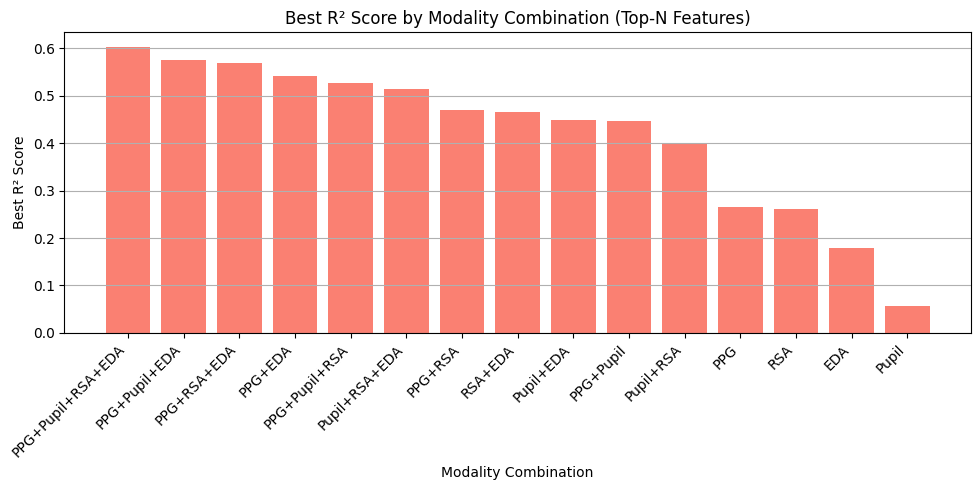

In [ ]:
import itertools
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장 초기화
best_results = []
importance_plot_dir = "./modality_importance_plots"
os.makedirs(importance_plot_dir, exist_ok=True)

# ✅ 각 조합별 반복
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X = window_df_all[selected_features]
    y = window_df_all["anxiety_mean"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 전체 feature로 학습 후 importance 추출
    full_model = RandomForestRegressor(random_state=42)
    full_model.fit(X_train, y_train)
    importances = full_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # # 1️⃣ 중요도 시각화 저장
    # plt.figure(figsize=(10, 4))
    # sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20], palette="Blues_d")
    # plt.title(f"Top Feature Importance: {combo_name}")
    # plt.xlabel("Importance")
    # plt.tight_layout()
    # plt.savefig(os.path.join(importance_plot_dir, f"importance_{combo_name}.png"))
    # plt.close()

    # 2️⃣ N개씩 사용해 성능 비교
    best_r2 = -np.inf
    best_result = None

    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        X_top = X[top_features]
        X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
            X_top, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train_top, y_train_top)
        y_pred = model.predict(X_test_top)
        mae = mean_absolute_error(y_test_top, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_top, y_pred))
        r2 = r2_score(y_test_top, y_pred)

        if r2 > best_r2:
            best_result = {
                "Modality_Combination": combo_name,
                "Best_N": top_n,
                "R2": r2,
                "MAE": mae,
                "RMSE": rmse,
                "Top_Features": top_features
            }
            best_r2 = r2

    best_results.append(best_result)

# ✅ 전체 결과 정리
best_df = pd.DataFrame(best_results)
best_df.to_csv("best_feature_selection_results.csv", index=False)

# ✅ 2️⃣ 전체 조합 중 최고 R² 비교 시각화
plt.figure(figsize=(10, 5))
sorted_best = best_df.sort_values(by="R2", ascending=False)
plt.bar(sorted_best["Modality_Combination"], sorted_best["R2"], color="salmon")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² Score by Modality Combination (Top-N Features)")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("best_r2_by_combination.png")
plt.show()


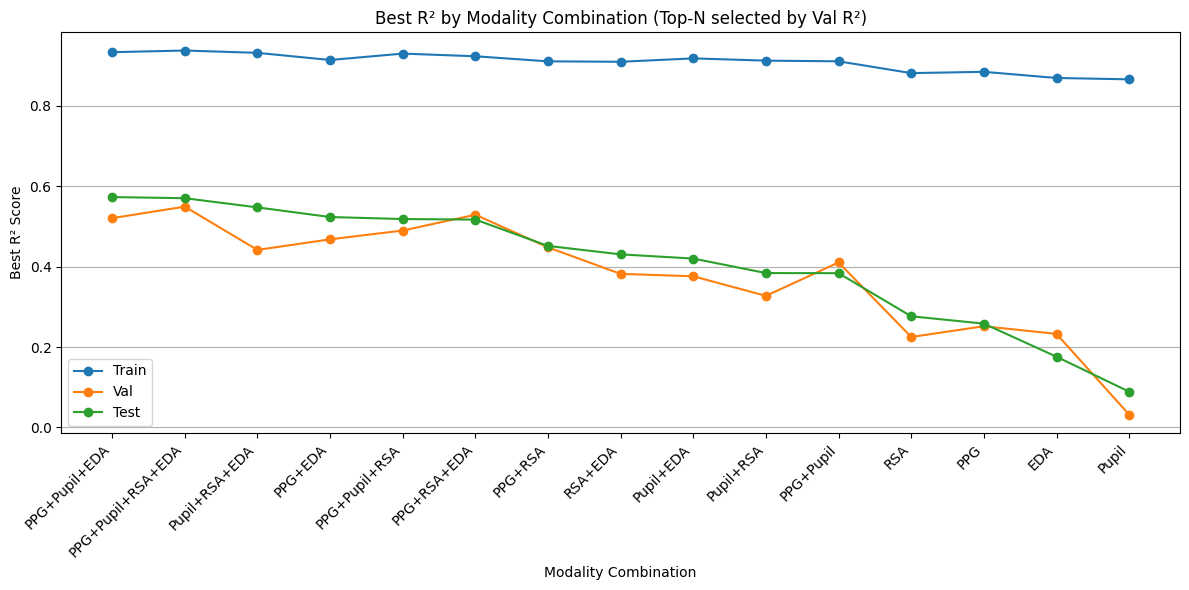

In [134]:
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장용
performance_records = []

# ✅ 각 조합별 루프
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X = window_df_all[selected_features]
    y = window_df_all["anxiety_mean"]

    # 먼저 10%를 test로 분리
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # 남은 90%에서 다시 10%를 validation으로 분리 → 전체의 9%
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)


    # ✅ feature importance 기반 정렬
    model_full = RandomForestRegressor(random_state=42)
    model_full.fit(X_train, y_train)
    importances = model_full.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # ✅ 1. Validation 성능 기준 best top-N 선택
    best_val_r2 = -np.inf
    best_n = None
    best_features = None
    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train[top_features], y_train)
        val_pred = model.predict(X_val[top_features])
        val_r2 = r2_score(y_val, val_pred)
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_n = top_n
            best_features = top_features

    # ✅ 2. 선택된 top-N feature로 Train/Val/Test 평가
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train[best_features], y_train)
    for split_name, X_, y_ in zip(["Train", "Val", "Test"],
                                  [X_train[best_features], X_val[best_features], X_test[best_features]],
                                  [y_train, y_val, y_test]):
        y_pred = model.predict(X_)
        r2 = r2_score(y_, y_pred)
        mae = mean_absolute_error(y_, y_pred)
        rmse = np.sqrt(mean_squared_error(y_, y_pred))
        performance_records.append({
            "Modality": combo_name,
            "TopN": best_n,
            "Split": split_name,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

# ✅ 결과 시각화
perf_df = pd.DataFrame(performance_records)

# 정렬: Test R² 기준 내림차순
best_by_split = (
    perf_df.sort_values(["Modality", "Split", "R2"], ascending=[True, True, False])
    .drop_duplicates(subset=["Modality", "Split"], keep="first")
)
pivot_df = best_by_split.pivot(index="Modality", columns="Split", values="R2")
pivot_df = pivot_df.sort_values(by="Test", ascending=False)

plt.figure(figsize=(12, 6))
for split in ["Train", "Val", "Test"]:
    if split in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[split], marker='o', label=split)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² by Modality Combination (Top-N selected by Val R²)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("best_r2_by_modality_valbased_sorted.png")
plt.show()


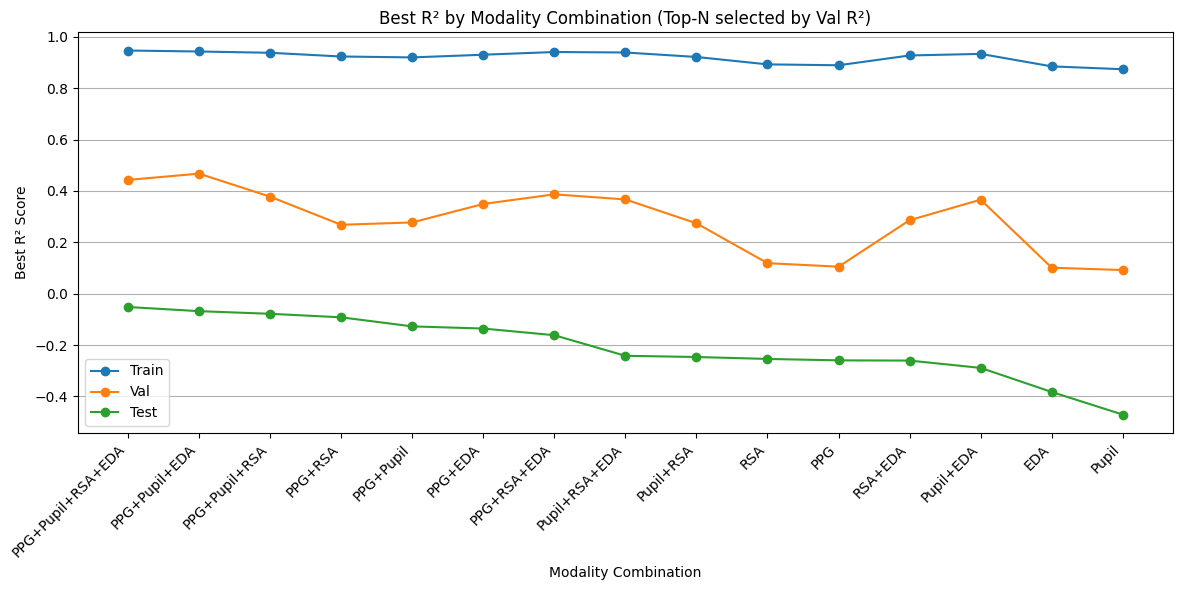

In [137]:
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장용
performance_records = []

# ✅ 각 조합별 루프
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    # ✅ 참여자별로 split 후 합치기
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list, y_test_list = [], []

    for pid, df_part in window_df_all.groupby("participant"):
        X_part = df_part[selected_features]
        y_part = df_part["anxiety_mean"]

        n_total = len(X_part)
        if n_total < 10:
            continue  # 너무 짧은 참여자는 제외

        idx_val_start = int(n_total * 0.8)
        idx_test_start = int(n_total * 0.9)

        X_train_list.append(X_part.iloc[:idx_val_start])
        y_train_list.append(y_part.iloc[:idx_val_start])

        X_val_list.append(X_part.iloc[idx_val_start:idx_test_start])
        y_val_list.append(y_part.iloc[idx_val_start:idx_test_start])

        X_test_list.append(X_part.iloc[idx_test_start:])
        y_test_list.append(y_part.iloc[idx_test_start:])

    # ✅ 전체 데이터 합치기
    X_train = pd.concat(X_train_list, axis=0)
    y_train = pd.concat(y_train_list, axis=0)
    X_val = pd.concat(X_val_list, axis=0)
    y_val = pd.concat(y_val_list, axis=0)
    X_test = pd.concat(X_test_list, axis=0)
    y_test = pd.concat(y_test_list, axis=0)

    # ✅ feature importance 기반 정렬
    model_full = RandomForestRegressor(random_state=42)
    model_full.fit(X_train, y_train)
    importances = model_full.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # ✅ 1. Validation 성능 기준 best top-N 선택
    best_val_r2 = -np.inf
    best_n = None
    best_features = None
    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train[top_features], y_train)
        val_pred = model.predict(X_val[top_features])
        val_r2 = r2_score(y_val, val_pred)
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_n = top_n
            best_features = top_features

    # ✅ 2. 선택된 top-N feature로 Train/Val/Test 평가
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train[best_features], y_train)
    for split_name, X_, y_ in zip(["Train", "Val", "Test"],
                                  [X_train[best_features], X_val[best_features], X_test[best_features]],
                                  [y_train, y_val, y_test]):
        y_pred = model.predict(X_)
        r2 = r2_score(y_, y_pred)
        mae = mean_absolute_error(y_, y_pred)
        rmse = np.sqrt(mean_squared_error(y_, y_pred))
        performance_records.append({
            "Modality": combo_name,
            "TopN": best_n,
            "Split": split_name,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

# ✅ 결과 시각화
perf_df = pd.DataFrame(performance_records)

# 정렬: Test R² 기준 내림차순
best_by_split = (
    perf_df.sort_values(["Modality", "Split", "R2"], ascending=[True, True, False])
    .drop_duplicates(subset=["Modality", "Split"], keep="first")
)
pivot_df = best_by_split.pivot(index="Modality", columns="Split", values="R2")
pivot_df = pivot_df.sort_values(by="Test", ascending=False)

plt.figure(figsize=(12, 6))
for split in ["Train", "Val", "Test"]:
    if split in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[split], marker='o', label=split)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² by Modality Combination (Top-N selected by Val R²)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("best_r2_by_modality_valbased_sorted.png")
plt.show()


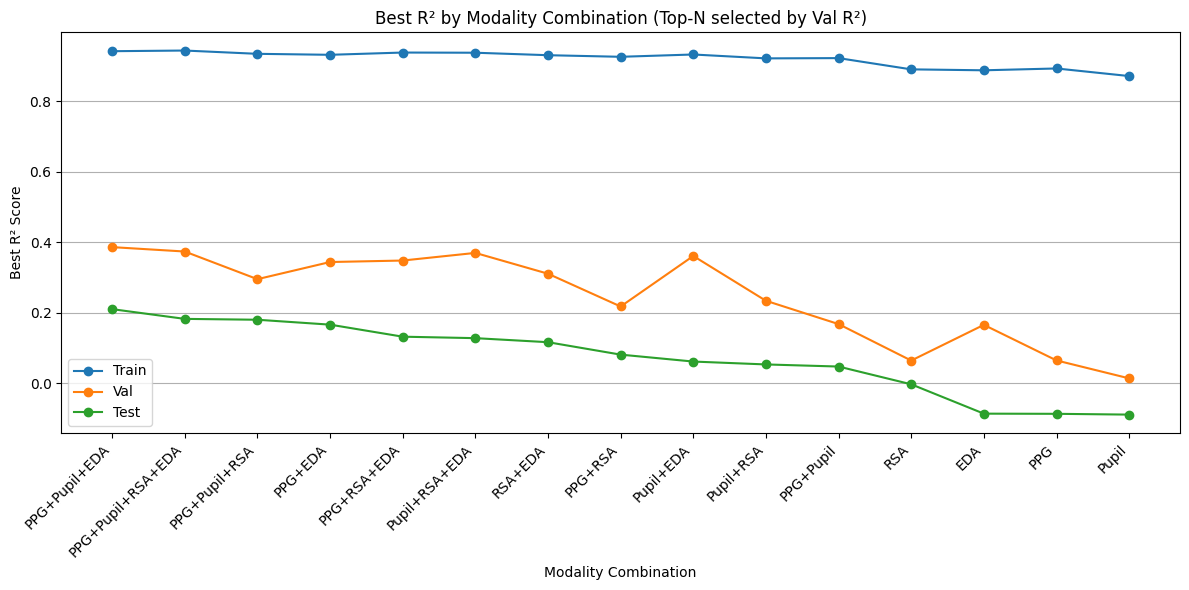

In [138]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장용
performance_records = []

# ✅ 참여자별 split 적용 후 전체 결합
split_dfs = {"Train": [], "Val": [], "Test": []}

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")

    if len(df_pid) <= 2:
        continue  # 60초 (2 window) 미만이면 제외 불가

    df_pid_trimmed = df_pid.iloc[:-2]  # 후반 60초 제외

    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val

    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

# ✅ 결합
df_splits = {
    k: pd.concat(v, axis=0).reset_index(drop=True)
    for k, v in split_dfs.items()
}

# ✅ 조합별 루프
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X_train = df_splits["Train"][selected_features]
    y_train = df_splits["Train"]["anxiety_mean"]
    X_val = df_splits["Val"][selected_features]
    y_val = df_splits["Val"]["anxiety_mean"]
    X_test = df_splits["Test"][selected_features]
    y_test = df_splits["Test"]["anxiety_mean"]

    # ✅ feature importance 정렬
    model_full = RandomForestRegressor(random_state=42)
    model_full.fit(X_train, y_train)
    importances = model_full.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # ✅ Validation R² 기준 best top-N feature 선택
    best_val_r2 = -np.inf
    best_n = None
    best_features = None
    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train[top_features], y_train)
        val_pred = model.predict(X_val[top_features])
        val_r2 = r2_score(y_val, val_pred)
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_n = top_n
            best_features = top_features

    # ✅ 최종 평가
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train[best_features], y_train)
    for split_name, X_, y_ in zip(["Train", "Val", "Test"],
                                  [X_train, X_val, X_test],
                                  [y_train, y_val, y_test]):
        y_pred = model.predict(X_[best_features])
        r2 = r2_score(y_, y_pred)
        mae = mean_absolute_error(y_, y_pred)
        rmse = np.sqrt(mean_squared_error(y_, y_pred))
        performance_records.append({
            "Modality": combo_name,
            "TopN": best_n,
            "Split": split_name,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

# ✅ 결과 시각화
perf_df = pd.DataFrame(performance_records)

# 정렬: Test R² 기준 내림차순
best_by_split = (
    perf_df.sort_values(["Modality", "Split", "R2"], ascending=[True, True, False])
    .drop_duplicates(subset=["Modality", "Split"], keep="first")
)
pivot_df = best_by_split.pivot(index="Modality", columns="Split", values="R2")
pivot_df = pivot_df.sort_values(by="Test", ascending=False)

plt.figure(figsize=(12, 6))
for split in ["Train", "Val", "Test"]:
    if split in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[split], marker='o', label=split)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² by Modality Combination (Top-N selected by Val R²)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("best_r2_by_modality_valbased_sorted.png")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

def plot_prediction_trend(y_true, y_pred, modality_name=""):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, s=40, label='Predicted vs True')

    # 추세선 (선형 회귀)
    model = LinearRegression()
    y_true_reshaped = np.array(y_true).reshape(-1, 1)
    model.fit(y_true_reshaped, y_pred)
    trend = model.predict(y_true_reshaped)
    plt.plot(y_true, trend, color='red', linestyle='--', label='Trend Line')

    # 대각선 (완벽 예측 기준선)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle=':', label='Perfect Prediction')

    plt.xlabel("True Anxiety")
    plt.ylabel("Predicted Anxiety")
    plt.title(f"Prediction vs True: {modality_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


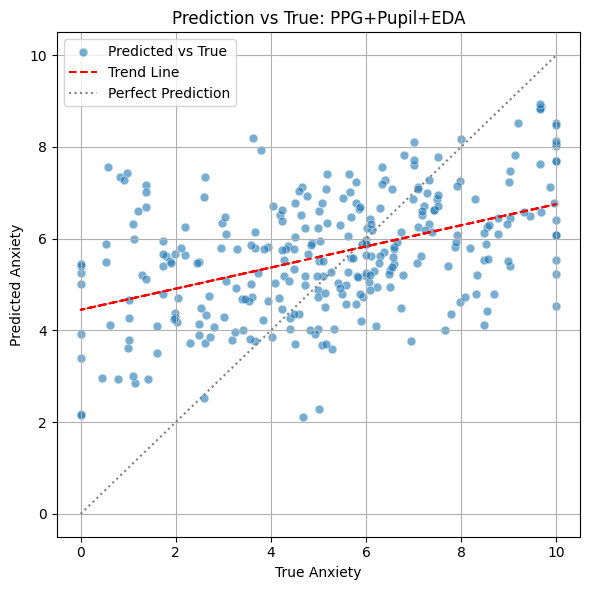

In [143]:
plot_prediction_trend(y_test, y_pred, modality_name="PPG+Pupil+EDA")

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Correlation 기반 feature 선택
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: col.corr(y))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features]

# 시각화: 선택된 feature의 상관관계 히트맵
def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation among Selected Features")
    plt.tight_layout()
    plt.show()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduce_features_by_pca(X, n_components=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    return pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# 시각화: 첫 두 PCA 컴포넌트
def plot_pca_scatter(X_pca, y):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y, cmap='viridis', s=30, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA - First Two Components")
    plt.colorbar(label='Anxiety')
    plt.tight_layout()
    plt.show()

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def select_features_rfecv(X, y, step=1, min_features_to_select=5):
    estimator = RandomForestRegressor(random_state=42)
    rfecv = RFECV(
        estimator=estimator,
        step=step,
        min_features_to_select=min_features_to_select,
        cv=KFold(5),
        scoring='r2',
        n_jobs=-1,
    )
    rfecv.fit(X, y)
    
    # 선택된 feature만 반환
    selected_features = X.columns[rfecv.support_]
    X_selected = X[selected_features]
    
    # 시각화: cross-validation score vs. number of features
    plt.figure(figsize=(6, 4))
    plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
    plt.xlabel("Number of Selected Features")
    plt.ylabel("Cross-Validation R² Score")
    plt.title("RFECV Feature Selection")
    plt.tight_layout()
    plt.show()
    
    print(f"Selected {len(selected_features)} features: {list(selected_features)}")
    return X_selected


def train_and_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # 시각화: 예측 vs 실제
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel("Actual Anxiety")
    plt.ylabel("Predicted Anxiety")
    plt.title(f"Prediction Result (R² = {r2:.2f})")
    plt.tight_layout()
    plt.show()
    
    return r2


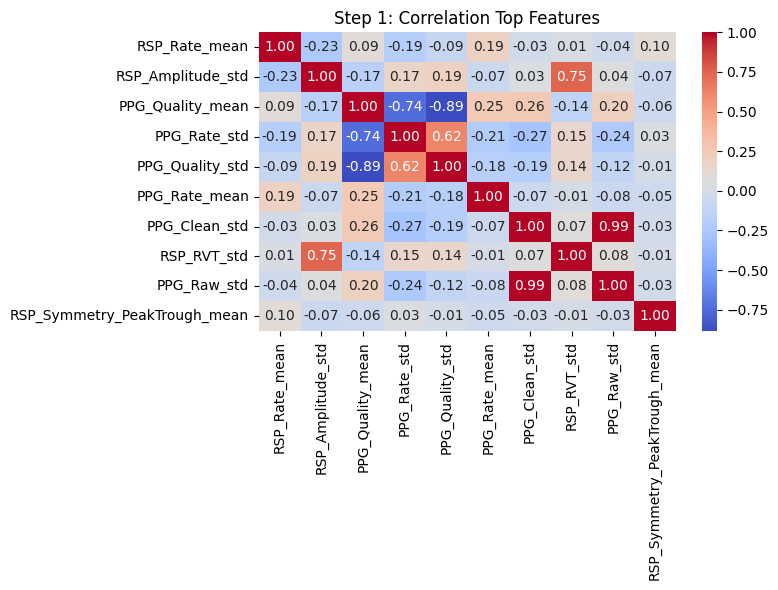

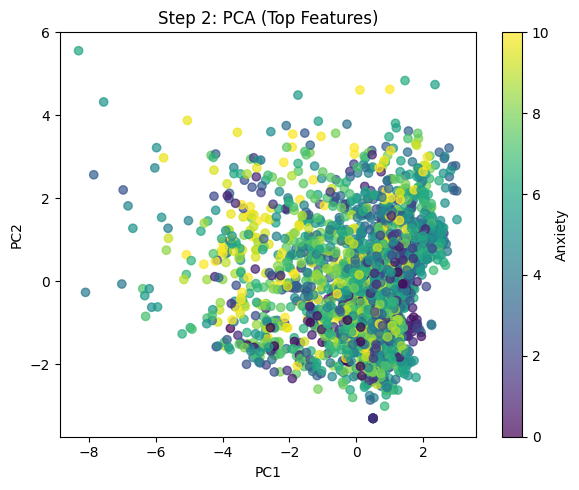

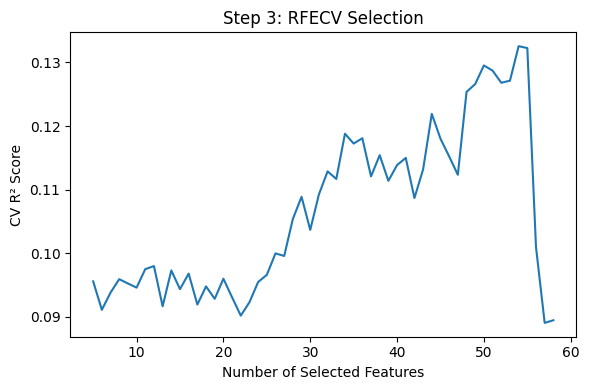

📊 R² Score Comparison
Step 1 (Top-Corr):   R² = 0.290
Step 2 (PCA):        R² = 0.184
Step 3 (RFECV):      R² = 0.551

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['pupilL_mean', 'pupilR_std', 'PPG_Clean_std', 'PPG_Rate_mean', 'PPG_Quality_mean', 'EDA_Raw_mean', 'EDA_Tonic_mean', 'RSP_Raw_mean', 'RSP_Raw_std']


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_87636\2154084311.py:117: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_87636\2154084311.py:117: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


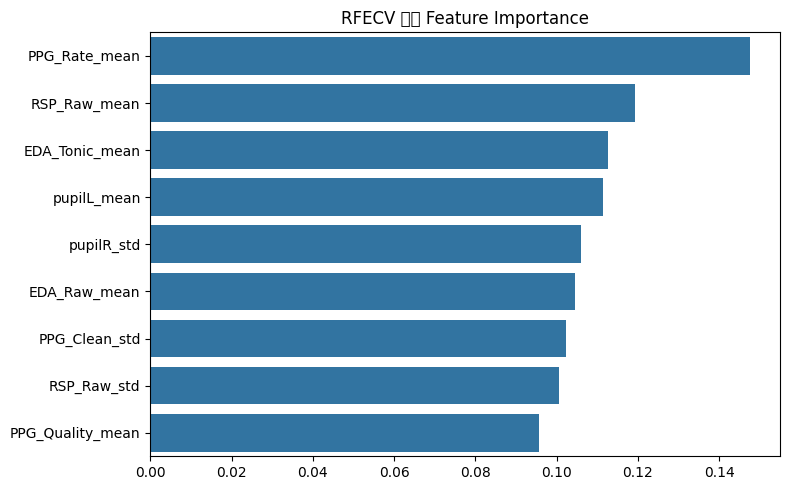

In [13]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

model = RandomForestRegressor(random_state=42)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(rfecv.n_features_in_, rfecv.n_features_in_ - len(rfecv.cv_results_["mean_test_score"]), -1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")
print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)
print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))

final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_rfecv, y_full)
importances = final_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [selected_rfecv_features[i] for i in sorted_idx]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[sorted_idx], y=sorted_features)
plt.title("RFECV 최종 Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
# 중요도 상위 20개 feature만 추출
top_n = 12
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top20_features = [feature_cols[i] for i in indices[:top_n]]

# X 재정의
X = window_df_all[top20_features]
y = window_df_all['anxiety_mean']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 모델 학습
from sklearn.ensemble import RandomForestRegressor
model_top = RandomForestRegressor(random_state=42)
model_top.fit(X_train, y_train)

# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model_top.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


MAE: 1.272, RMSE: 1.630, R²: 0.603


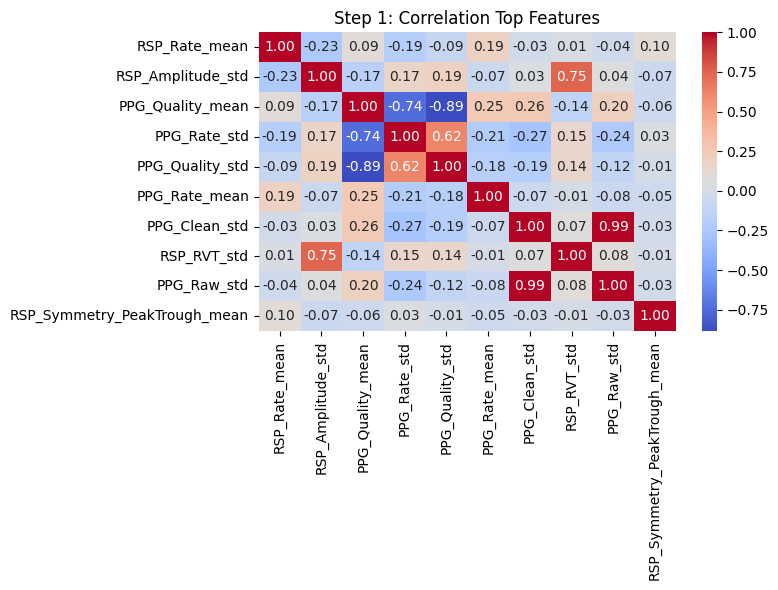

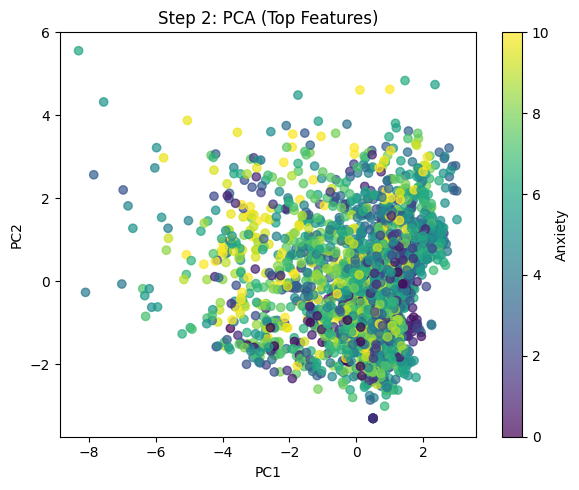

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.p

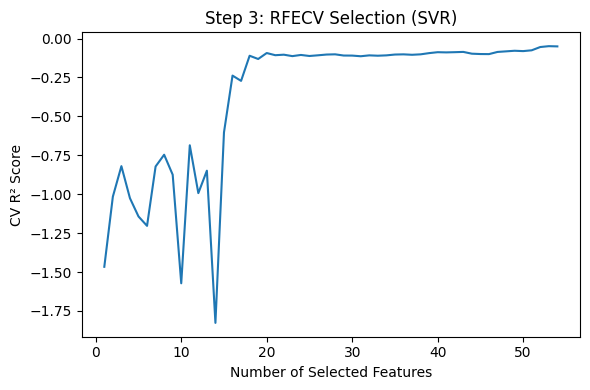

📊 R² Score Comparison (SVR)
Step 1 (Top-Corr):   R² = -0.327
Step 2 (PCA):        R² = 0.011
Step 3 (RFECV):      R² = -0.007

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['PPG_Clean_std', 'PPG_Quality_std', 'RSP_Clean_std', 'RSP_RVT_mean', 'RSP_Phase_std', 'RSP_Symmetry_RiseDecay_std']


c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ✅ Step 0: 유효 feature 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

# ✅ Step 0.5: participant별 split 적용
split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ✅ Step 1: Correlation 기반 Top-N Feature
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ✅ Step 2: PCA (Top-N Correlation Feature 기반)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ✅ Step 3: RFECV Wrapper Feature Selection (전체 feature 대상)
model = LinearSVR()
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(len(rfecv.cv_results_["mean_test_score"]), 0, -1), rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection (SVR)")
plt.tight_layout()
plt.show()

# ✅ 평가 함수
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearSVR()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ✅ R² Score 비교
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (SVR)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")
print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)
print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


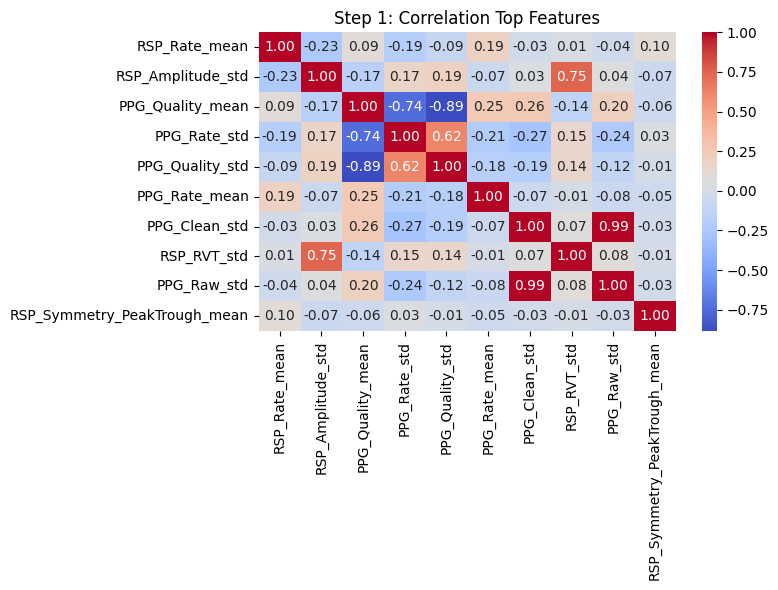

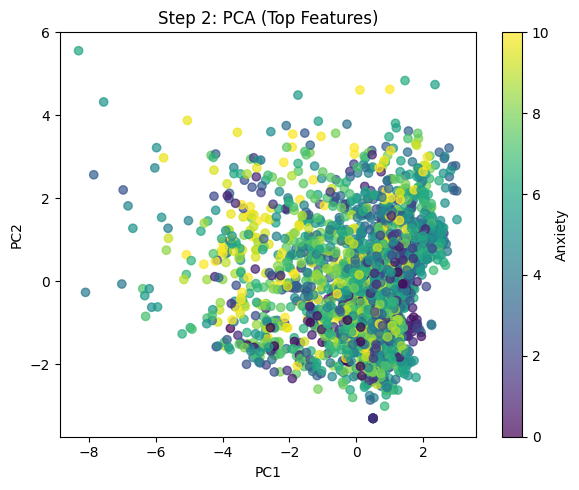

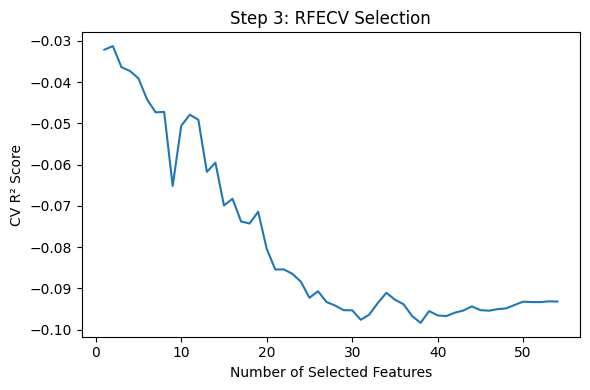

📊 R² Score Comparison (Ridge)
Step 1 (Top-Corr):   R² = 0.029
Step 2 (PCA):        R² = 0.027
Step 3 (RFECV):      R² = 0.019

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['PPG_Raw_std', 'PPG_Clean_std', 'EDA_Raw_std', 'EDA_Clean_std', 'RSP_Clean_std', 'RSP_RVT_mean']


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
# 전처리된 DataFrame(window_df_all)과 anxiety_mean 컬럼이 있다고 가정
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
model = Ridge()
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (Ridge)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


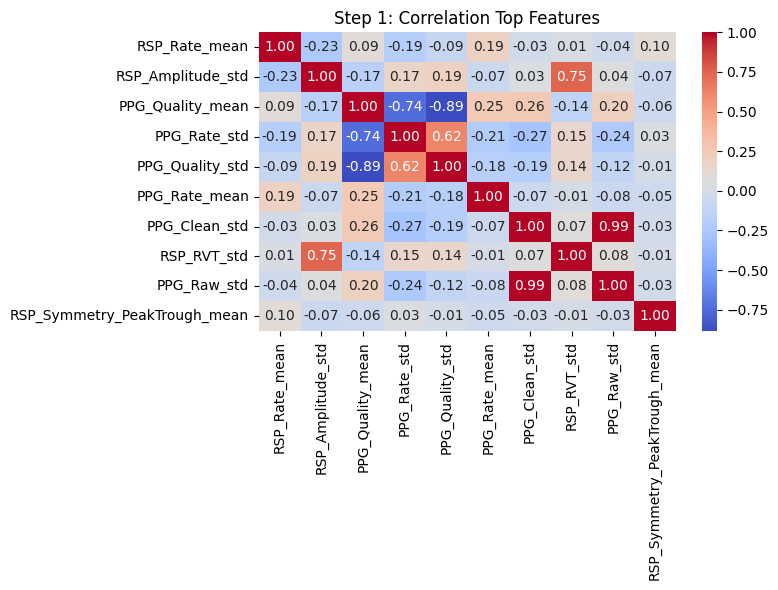

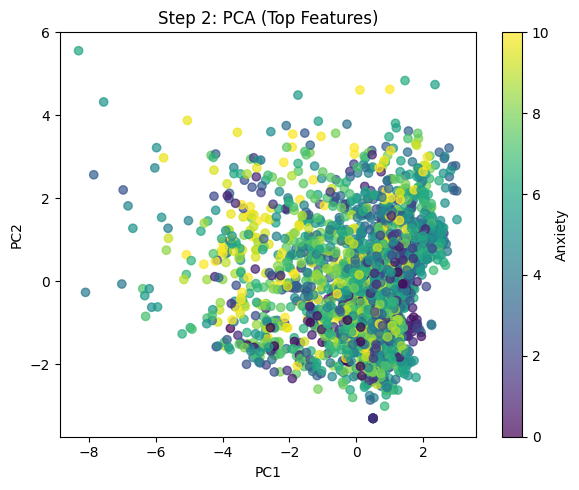

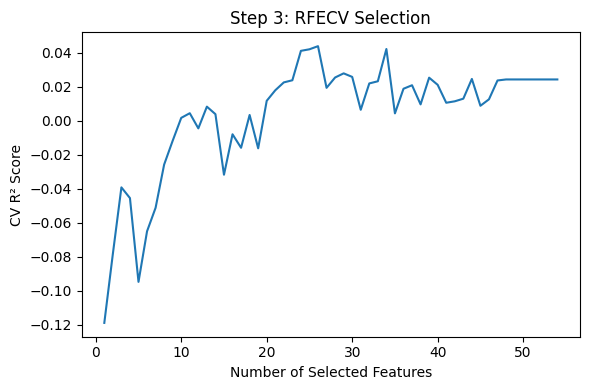

📊 R² Score Comparison (XGBoost)
Step 1 (Top-Corr):   R² = 0.201
Step 2 (PCA):        R² = 0.043
Step 3 (RFECV):      R² = 0.508

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['pupilR_mean', 'pupilR_std', 'PPG_Raw_std', 'PPG_Clean_std', 'PPG_Rate_mean', 'PPG_Rate_std', 'PPG_Quality_mean', 'PPG_Quality_std', 'EDA_Raw_mean', 'EDA_Clean_mean', 'EDA_Tonic_mean', 'EDA_Tonic_std', 'EDA_Phasic_std', 'SCR_Amplitude_mean', 'SCR_RiseTime_mean', 'SCR_Recovery_mean', 'SCR_RecoveryTime_mean', 'RSP_Raw_mean', 'RSP_Raw_std', 'RSP_Clean_std', 'RSP_Amplitude_mean', 'RSP_Amplitude_std', 'RSP_Rate_mean', 'RSP_Rate_std', 'RSP_RVT_mean', 'RSP_RVT_std', 'RSP_Symmetry_PeakTrough_mean', 'RSP_Symmetry_PeakTrough_std', 'RSP_Symmetry_RiseDecay_mean', 'RSP_Symmetry_RiseDecay_std']


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
model = XGBRegressor(random_state=42, n_jobs=-1)
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = XGBRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (XGBoost)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


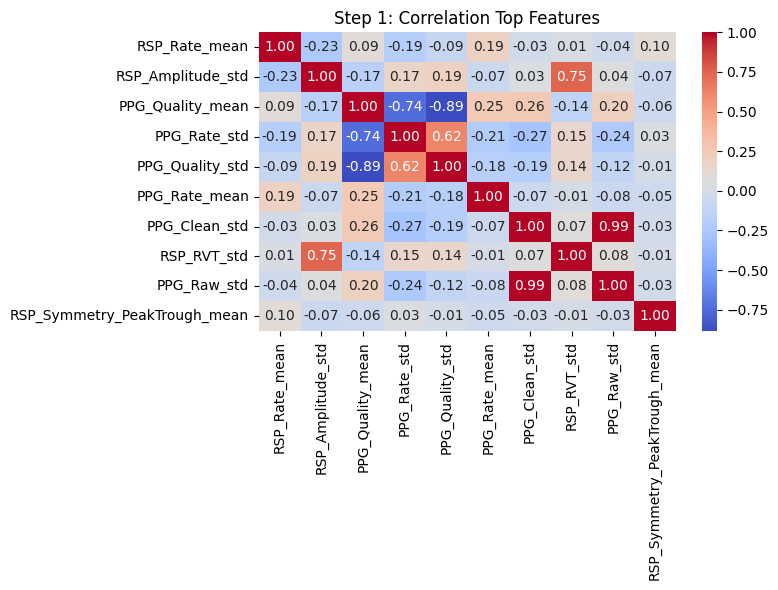

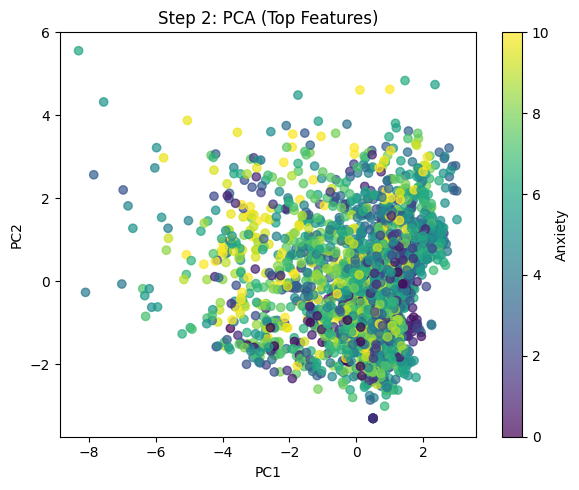

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10196
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 58
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10192
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 57
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 56
[LightGBM] [Info] Start tra

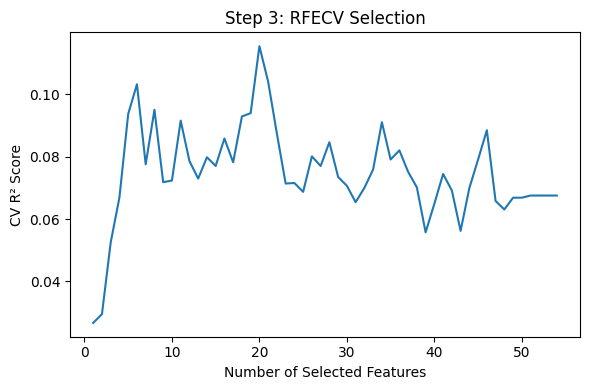

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 10
[LightGBM] [Info] Start training from score 5.505321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 5
[LightGBM] [Info] Start training from score 5.505321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 24
[LightGBM] [Info] Start trainin

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
model = lgb.LGBMRegressor(random_state=42)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (LightGBM)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


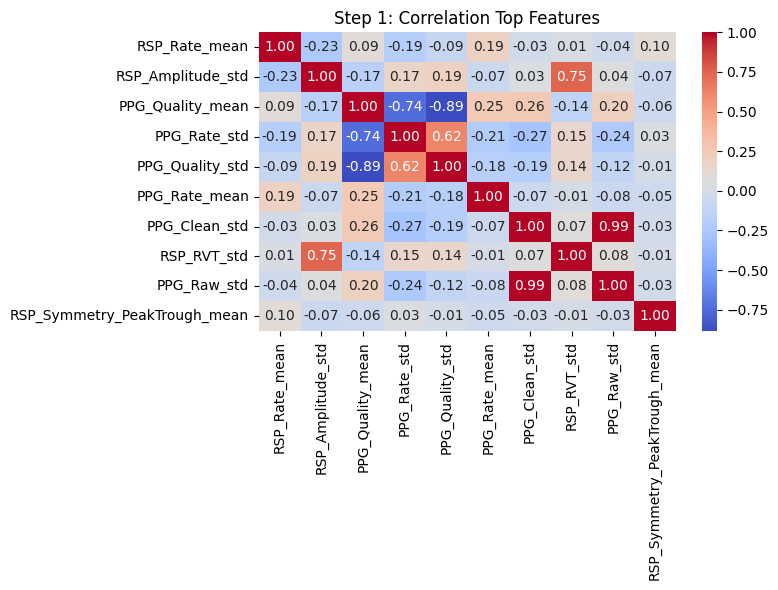

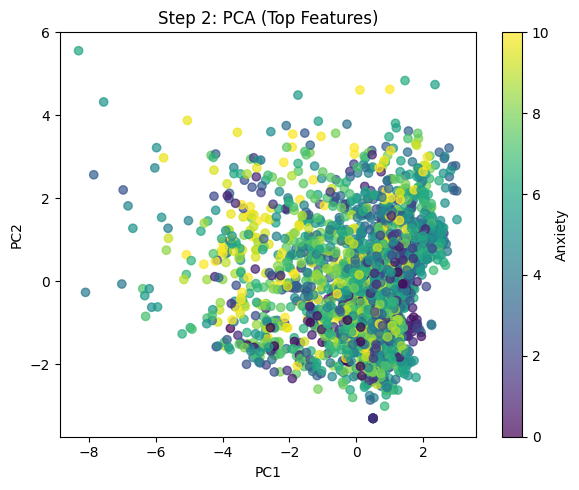

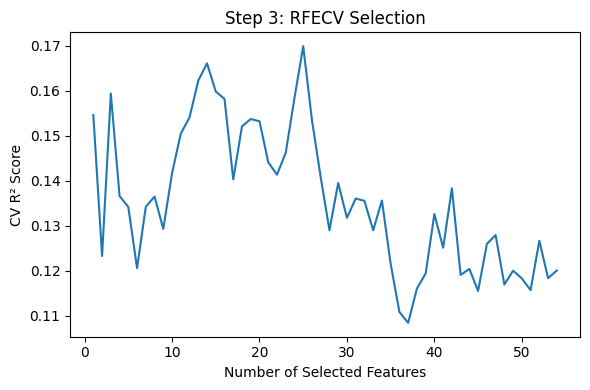

📊 R² Score Comparison (CatBoost)
Step 1 (Top-Corr):   R² = 0.307
Step 2 (PCA):        R² = 0.183
Step 3 (RFECV):      R² = 0.611

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['pupilL_mean', 'pupilL_std', 'pupilR_mean', 'pupilR_std', 'PPG_Raw_std', 'PPG_Clean_std', 'PPG_Rate_mean', 'PPG_Rate_std', 'PPG_Quality_mean', 'PPG_Quality_std', 'EDA_Raw_mean', 'EDA_Clean_mean', 'EDA_Clean_std', 'EDA_Tonic_mean', 'EDA_Tonic_std', 'EDA_Phasic_std', 'RSP_Raw_mean', 'RSP_Raw_std', 'RSP_Clean_std', 'RSP_Amplitude_mean', 'RSP_Amplitude_std', 'RSP_Rate_mean', 'RSP_Rate_std', 'RSP_RVT_mean', 'RSP_RVT_std', 'RSP_Symmetry_PeakTrough_mean', 'RSP_Symmetry_PeakTrough_std', 'RSP_Symmetry_RiseDecay_mean', 'RSP_Symmetry_RiseDecay_std']


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
model = CatBoostRegressor(verbose=0, random_state=42)
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = CatBoostRegressor(verbose=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (CatBoost)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))



📊 Baseline (Default CatBoost) Results:
R²    = 0.641
RMSE  = 1.477
MAE   = 1.157
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🏆 Grid Search Best Model Results:
R²    = 0.646
RMSE  = 1.467
MAE   = 1.124

✅ Best Params: {'model__depth': 8, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.1}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_38896\607635878.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


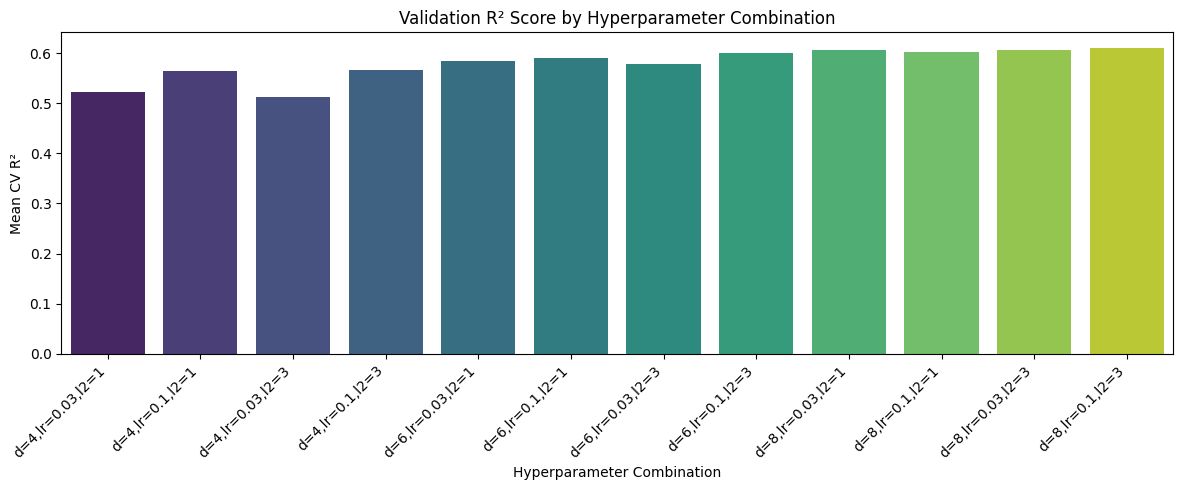


📌 일부 modality가 제거된 participant 목록:
PID 001 → removed: RSP
PID 002 → removed: PPG
PID 006 → removed: RSP
PID 009 → removed: RSP
PID 010 → removed: RSP
PID 014 → removed: RSP
PID 017 → removed: RSP
PID 019 → removed: PPG
PID 023 → removed: RSP
PID 025 → removed: PPG
PID 026 → removed: PPG
PID 027 → removed: RSP
PID 034 → removed: PPG
PID 038 → removed: PPG
PID 039 → removed: RSP
PID 042 → removed: PPG
PID 043 → removed: RSP
PID 045 → removed: RSP
PID 046 → removed: PPG
PID 048 → removed: EDA
PID 050 → removed: RSP
PID 055 → removed: RSP
PID 056 → removed: RSP
PID 061 → removed: EDA
PID 062 → removed: RSP
PID 065 → removed: RSP
PID 067 → removed: PPG
PID 071 → removed: RSP
PID 074 → removed: RSP
PID 075 → removed: EDA
PID 076 → removed: RSP
PID 078 → removed: RSP
PID 080 → removed: RSP
PID 082 → removed: RSP
PID 083 → removed: RSP
PID 089 → removed: RSP
PID 093 → removed: EDA
PID 099 → removed: EDA
PID 101 → removed: RSP
PID 103 → removed: EDA
PID 104 → removed: RSP


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- Step 0: Load modality exclusion lists ----------
ppg_exclude_df = pd.read_csv("./abnormal_ppg_anonymized.csv")
rsp_exclude_df = pd.read_csv("./abnormal_rsp_anonymized.csv")
eda_exclude_df = pd.read_csv("./abnormal_eda_anonymized.csv")

exclude_ppg_ids = set(ppg_exclude_df.loc[ppg_exclude_df["exclude_flag_ppg"], "Anonymized_ID"].dropna().astype(int))
exclude_rsp_ids = set(rsp_exclude_df.loc[rsp_exclude_df["exclude_flag_rsp"], "Anonymized_ID"].dropna().astype(int))
exclude_eda_ids = set(eda_exclude_df.loc[eda_exclude_df["exclude_flag_eda"], "Anonymized_ID"].dropna().astype(int))

# ---------- Step 1: Prepare main dataframe ----------
window_df_all['participant'] = window_df_all['participant'].astype(int)

exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))

    if len(df_pid) <= 2:
        continue

    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val

    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

# ---------- Step 2: Combine and define features ----------
df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)

valid_feature_cols = [
    col for col in df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 3: RFECV Feature Selection ----------
model = CatBoostRegressor(verbose=0, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

rfecv = RFECV(
    estimator=model,
    step=1,
    min_features_to_select=5,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
rfecv.fit(X_scaled, y_full)

selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Step 4: Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_rfecv, y_full, test_size=0.2, random_state=42
)

# ---------- Step 5: Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default CatBoost) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- Step 6: GridSearchCV ----------
param_grid = {
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.03, 0.1],
    'model__l2_leaf_reg': [1, 3]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- Step 7: 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- Step 8: GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__depth']},lr={row['param_model__learning_rate']},l2={row['param_model__l2_leaf_reg']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()

# ---------- Step 9: 제거된 participant 목록 출력 ----------
print("\n📌 일부 modality가 제거된 participant 목록:")
for pid, modalities in removed_participants:
    print(f"PID {pid:03d} → removed: {', '.join(modalities)}")


In [17]:
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor

# ✅ exclude 및 feature 선택
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 별 feature 정리
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ modality 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ best CatBoost 파라미터 세팅
catboost_params = {
    'depth': 8,
    'l2_leaf_reg': 3,
    'learning_rate': 0.1,
    'verbose': 0,
    'random_state': 42
}

# ✅ 결과 저장 초기화
best_results = []

for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X = window_df_all[selected_features]
    y = window_df_all["anxiety_mean"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 전체 feature로 학습 후 importance 추출
    full_model = CatBoostRegressor(**catboost_params)
    full_model.fit(X_train, y_train)
    importances = full_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # ✅ N개씩 사용해 성능 비교
    best_r2 = -np.inf
    best_result = None

    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        X_top = X[top_features]
        X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
            X_top, y, test_size=0.2, random_state=42)

        model = CatBoostRegressor(**catboost_params)
        model.fit(X_train_top, y_train_top)
        y_pred = model.predict(X_test_top)
        mae = mean_absolute_error(y_test_top, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_top, y_pred))
        r2 = r2_score(y_test_top, y_pred)

        if r2 > best_r2:
            best_result = {
                "Modality_Combination": combo_name,
                "Best_N": top_n,
                "R2": r2,
                "MAE": mae,
                "RMSE": rmse,
                "Top_Features": top_features
            }
            best_r2 = r2

    best_results.append(best_result)

# ✅ 전체 결과 저장
best_df = pd.DataFrame(best_results)
best_df.to_csv("best_feature_selection_results_catboost.csv", index=False)

# ✅ 시각화
plt.figure(figsize=(10, 5))
sorted_best = best_df.sort_values(by="R2", ascending=False)
plt.bar(sorted_best["Modality_Combination"], sorted_best["R2"], color="skyblue")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination", fontsize=14, fontweight='bold')
plt.ylabel("Best R² Score", fontsize=14, fontweight='bold')
plt.title("Best R² Score by Modality Combination (CatBoost)", fontsize=16, fontweight='bold')
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("best_r2_by_combination_catboost.png", dpi=300)
plt.show()


KeyboardInterrupt: 

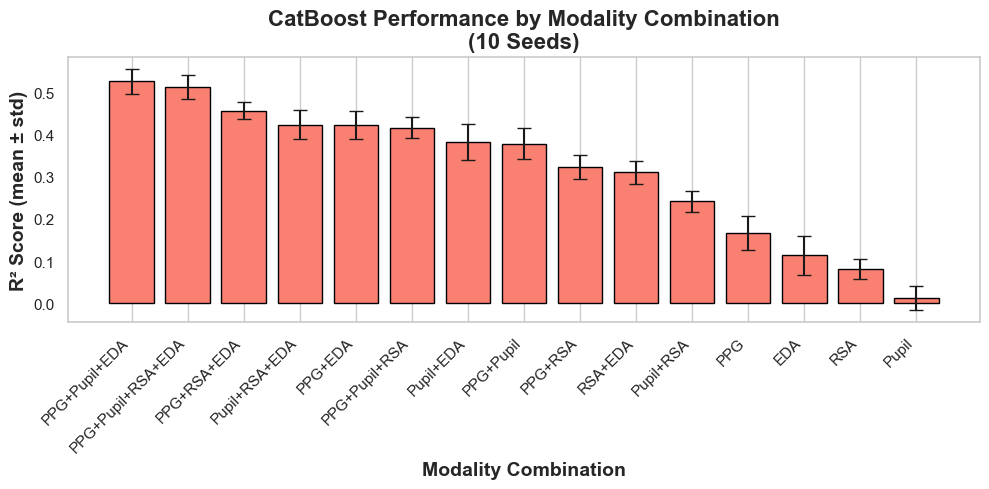

In [29]:
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor

# ✅ exclude 및 feature 선택
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 별 feature 정리
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ modality 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ best CatBoost 파라미터 세팅
catboost_base_params = {
    'depth': 8,
    'l2_leaf_reg': 3,
    'learning_rate': 0.1,
    'verbose': 0
}

seed_list = list(range(10))  # seed 0~9

# ✅ 결과 저장 초기화
combo_results = []

for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    r2_list = []

    for seed in seed_list:
        X = window_df_all[selected_features]
        y = window_df_all["anxiety_mean"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        model = CatBoostRegressor(**catboost_base_params, random_state=seed)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_list.append(r2)

    combo_results.append({
        "Modality_Combination": combo_name,
        "R2_mean": np.mean(r2_list),
        "R2_std": np.std(r2_list),
        "R2_all": r2_list
    })

# ✅ 결과 저장
result_df = pd.DataFrame(combo_results)
result_df.to_csv("catboost_r2_seedwise_results.csv", index=False)

# ✅ 시각화 (Error Bar)
plt.figure(figsize=(10, 5))
sorted_df = result_df.sort_values("R2_mean", ascending=False)
plt.bar(sorted_df["Modality_Combination"], sorted_df["R2_mean"],
        yerr=sorted_df["R2_std"], capsize=5, color="salmon", edgecolor="black")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination", fontsize=14, fontweight='bold')
plt.ylabel("R² Score (mean ± std)", fontsize=14, fontweight='bold')
plt.title("CatBoost Performance by Modality Combination\n(10 Seeds)", fontsize=16, fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("catboost_r2_with_errorbar.png", dpi=300)
plt.show()


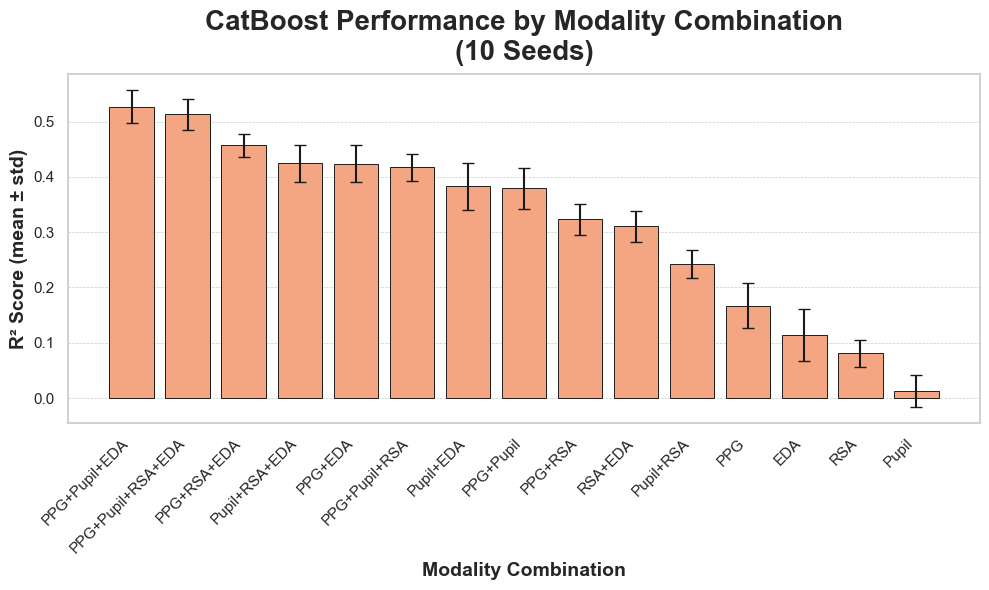

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 세팅
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'font.family': 'Arial'  # 논문용 폰트 추천: 'Arial', 'Helvetica'
})

# 데이터 정렬
sorted_df = result_df.sort_values("R2_mean", ascending=False)

# Figure 작게
plt.figure(figsize=(10, 6))

# 막대 + 에러바
plt.bar(
    sorted_df["Modality_Combination"],
    sorted_df["R2_mean"],
    yerr=sorted_df["R2_std"],
    capsize=4,
    color="#f4a582",              # 살구색 톤 (논문 스타일)
    edgecolor="black",
    linewidth=0.6
)

# 축 설정
plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination",fontsize=14, fontweight='bold')
plt.ylabel("R² Score (mean ± std)",fontsize=14, fontweight='bold')
plt.title("CatBoost Performance by Modality Combination\n(10 Seeds)",fontsize=20, fontweight='bold', pad=10)

# grid 설정
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', visible=False)

# 저장 및 출력
plt.tight_layout()
plt.savefig("catboost_r2_with_errorbar_clean.png", dpi=300, transparent=True)
plt.show()


In [22]:
sorted_best

Modality_Combination  Best_N        R2       MAE      RMSE  \
14    PPG+Pupil+RSA+EDA      14  0.637346  1.187745  1.568460   
11        PPG+Pupil+EDA       7  0.619958  1.212214  1.605620   
13        Pupil+RSA+EDA      13  0.575785  1.295078  1.696369   
10        PPG+Pupil+RSA      12  0.565773  1.291830  1.716270   
12          PPG+RSA+EDA      13  0.564746  1.311961  1.718297   
6               PPG+EDA      10  0.511253  1.361115  1.820828   
8             Pupil+EDA       8  0.472350  1.464109  1.891907   
5               PPG+RSA      12  0.461956  1.508435  1.910451   
4             PPG+Pupil      10  0.460928  1.478799  1.912275   
9               RSA+EDA      13  0.402460  1.572896  2.013310   
7             Pupil+RSA       9  0.345298  1.633175  2.107409   
0                   PPG       6  0.272902  1.722503  2.220872   
3                   EDA      19  0.155563  1.869408  2.393375   
2                   RSA      11  0.118068  1.988887  2.445933   
1                 Pupil       4  0.043954  2.009730  2.546633   

                                         Top_Features  
14  [PPG_Rate_mean, PPG_Clean_std, EDA_Tonic_mean,...  
11  [PPG_Rate_mean, pupilR_mean, PPG_Clean_std, pu...  
13  [RSP_Rate_mean, EDA_Tonic_mean, pupilR_mean, p...  
10  [PPG_Rate_mean, pupilR_mean, PPG_Clean_std, pu...  
12  [PPG_Rate_mean, PPG_Clean_std, RSP_Rate_mean, ...  
6   [PPG_Rate_mean, PPG_Rate_std, EDA_Tonic_mean, ...  
8   [pupilR_mean, pupilL_mean, EDA_Tonic_mean, pup...  
5   [PPG_Rate_mean, PPG_Clean_std, PPG_Quality_mea...  
4   [PPG_Rate_mean, pupilR_mean, PPG_Clean_std, PP...  
9   [RSP_Rate_mean, RSP_Rate_std, EDA_Tonic_mean, ...  
7   [pupilR_mean, pupilR_std, RSP_Rate_std, pupilL...  
0   [PPG_Rate_mean, PPG_Rate_std, PPG_Clean_std, P...  
3   [EDA_Phasic_std, EDA_Phasic_mean, EDA_Tonic_st...  
2   [RSP_Rate_mean, RSP_Rate_std, RSP_Symmetry_Pea...  
1   [pupilR_mean, pupilL_mean, pupilR_std, pupilL_...


📊 Baseline (Default Random Forest) Results:
R²    = 0.633
RMSE  = 1.495
MAE   = 1.169
Fitting 5 folds for each of 48 candidates, totalling 240 fits

🏆 Grid Search Best Model Results:
R²    = 0.639
RMSE  = 1.483
MAE   = 1.175

✅ Best Params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_38896\2511444828.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


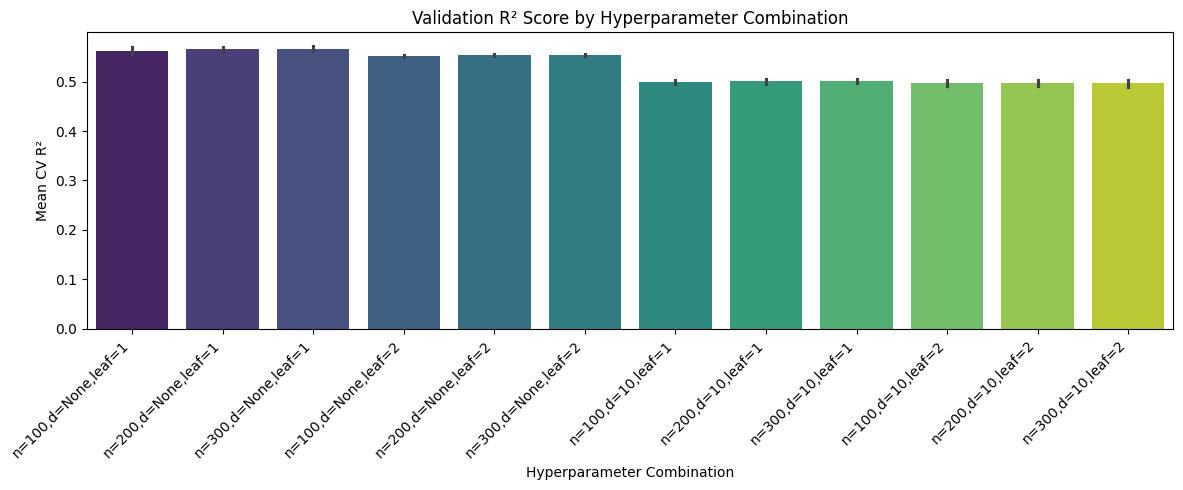

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = RandomForestRegressor(random_state=42, n_jobs=-1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

rfecv = RFECV(
    estimator=model,
    step=1,
    min_features_to_select=5,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
rfecv.fit(X_scaled, y_full)

selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default Random Forest) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10],
    'model__min_samples_leaf': [1, 2],
    'model__min_samples_split': [2, 5],
    'model__max_features': ['sqrt', 0.5]  # 'auto' 제거
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"n={row['param_model__n_estimators']},d={row['param_model__max_depth']},leaf={row['param_model__min_samples_leaf']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



📊 Baseline (Default XGBoost) Results:
R²    = 0.544
RMSE  = 1.665
MAE   = 1.296
Fitting 5 folds for each of 108 candidates, totalling 540 fits

🏆 Grid Search Best Model Results:
R²    = 0.632
RMSE  = 1.497
MAE   = 1.156

✅ Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 300, 'model__subsample': 0.8}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_38896\2091582347.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


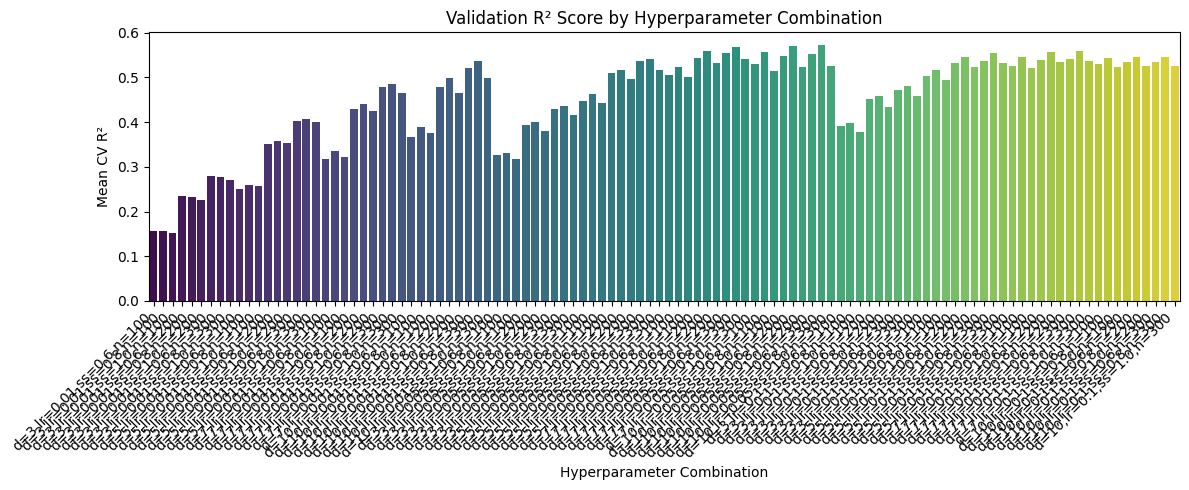

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = XGBRegressor(verbosity=0, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(verbosity=0, random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default XGBoost) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(verbosity=0, random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10194
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 58
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10190
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 57
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10185
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 56
[LightGBM] [Info] Start tra

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 16
[LightGBM] [Info] Start training from score 5.513562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_38896\3441122682.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


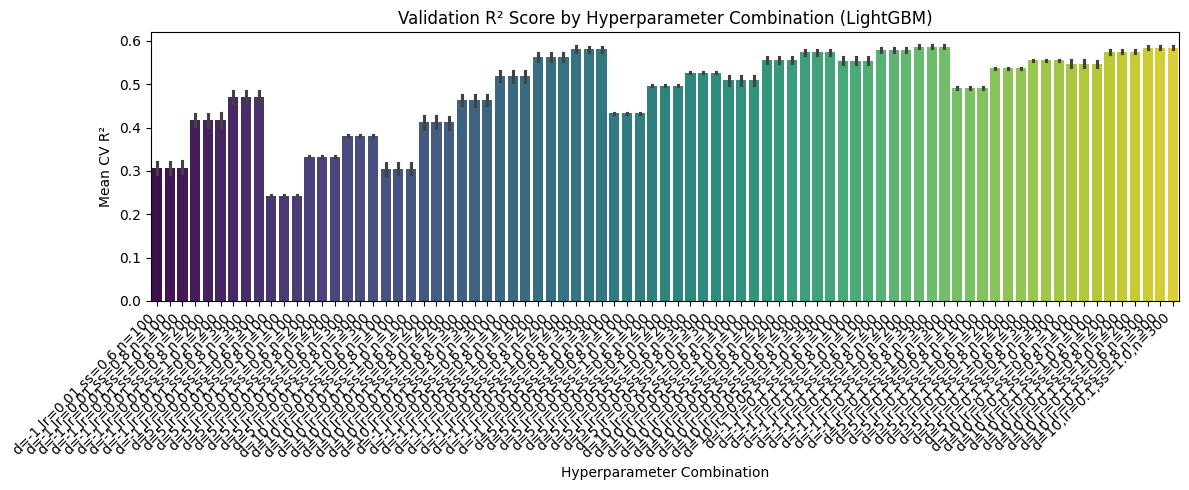

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = LGBMRegressor(random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default LightGBM) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [-1, 5, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__num_leaves': [15, 31, 63],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [0, 0.1]
}


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (LightGBM)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = GradientBoostingRegressor(random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default GradientBoosting) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 3]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (GBR)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()


ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = GradientBoostingRegressor(random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default GradientBoosting) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.6, 0.8, 1.0]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (GradientBoosting)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()


ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [23]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- NaN 포함 column 제거 ----------
X_clean = X_full.loc[:, X_full.isna().mean() == 0.0].copy()
y_clean = y_full.loc[X_clean.index].reset_index(drop=True)
X_clean = X_clean.reset_index(drop=True)

# ---------- Step 1: RFECV (LinearSVR 사용) ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

rfecv_model = LinearSVR(random_state=42, max_iter=10000)
rfecv = RFECV(estimator=rfecv_model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_clean)

selected_rfecv_features = X_clean.columns[rfecv.support_]
print(f"\n✅ Selected Features from RFECV ({len(selected_rfecv_features)}):")
print(selected_rfecv_features.tolist())

X_selected = X_clean[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y_clean, test_size=0.2, random_state=42)

# ---------- Baseline SVR ----------
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1))
])
baseline_pipeline.fit(X_trainval, y_trainval)
y_pred_baseline = baseline_pipeline.predict(X_test)

print("\n📊 Baseline SVR Results:")
print(f"R²    = {r2_score(y_test, y_pred_baseline):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred_baseline)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred_baseline):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 0.01, 0.1, 1],
    'model__epsilon': [0.05, 0.1, 0.2]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf'))
])

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid.fit(X_trainval, y_trainval)

# ---------- Best SVR 평가 ----------
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\n🏆 GridSearchCV Best SVR Results:")
print(f"R²    = {r2_score(y_test, y_pred_best):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred_best)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred_best):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")



✅ Selected Features from RFECV (5):
['SCR_Height_mean', 'SCR_Height_std', 'SCR_Amplitude_std', 'SCR_Recovery_mean', 'SCR_Recovery_std']

📊 Baseline SVR Results:
R²    = -0.004
RMSE  = 2.472
MAE   = 2.012
Fitting 5 folds for each of 48 candidates, totalling 240 fits

🏆 GridSearchCV Best SVR Results:
R²    = -0.069
RMSE  = 2.551
MAE   = 2.032

✅ Best Params: {'model__C': 100, 'model__epsilon': 0.2, 'model__gamma': 1}


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn.kernel_ridge import KernelRidge



# ---------- Step 0: Load modality exclusion lists ----------
ppg_exclude_df = pd.read_csv("./abnormal_ppg_anonymized.csv")
rsp_exclude_df = pd.read_csv("./abnormal_rsp_anonymized.csv")
eda_exclude_df = pd.read_csv("./abnormal_eda_anonymized.csv")

exclude_ppg_ids = set(ppg_exclude_df.loc[ppg_exclude_df["exclude_flag_ppg"], "Anonymized_ID"].dropna().astype(int))
exclude_rsp_ids = set(rsp_exclude_df.loc[rsp_exclude_df["exclude_flag_rsp"], "Anonymized_ID"].dropna().astype(int))
exclude_eda_ids = set(eda_exclude_df.loc[eda_exclude_df["exclude_flag_eda"], "Anonymized_ID"].dropna().astype(int))

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- NaN 포함 column 제거 ----------
X_clean = X_full.loc[:, X_full.isna().mean() == 0.0].copy()
y_clean = y_full.loc[X_clean.index].reset_index(drop=True)
X_clean = X_clean.reset_index(drop=True)

# ---------- Step 1: RFECV ----------
model = Ridge()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_clean)
selected_rfecv_features = X_clean.columns[rfecv.support_]
X_rfecv = X_clean[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_clean, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default Ridge) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KernelRidge())
])

param_grid = {
    'model__alpha': np.logspace(-3, 2, 6),
              # for 'poly'
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# # ---------- GridSearchCV 결과 시각화 ----------
# cv_results = pd.DataFrame(grid.cv_results_)
# cv_results['param_combo'] = cv_results.apply(
#     lambda row: f"alpha={row['param_model__alpha']},kernel={row['param_model__kernel']},gamma={row.get('param_model__gamma', 'NA')},degree={row.get('param_model__degree', 'NA')}",
#     axis=1
# )

# plt.figure(figsize=(12, 5))
# sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="coolwarm")
# plt.xticks(rotation=45, ha='right')
# plt.title("Validation R² Score by Hyperparameter Combination (KernelRidge)")
# plt.ylabel("Mean CV R²")
# plt.xlabel("Hyperparameter Combination")
# plt.tight_layout()
# plt.show()



📊 Baseline (Default Ridge) Results:
R²    = 0.017
RMSE  = 2.446
MAE   = 2.021
Fitting 5 folds for each of 6 candidates, totalling 30 fits

🏆 Grid Search Best Model Results:
R²    = -5.067
RMSE  = 6.077
MAE   = 5.567

✅ Best Params: {'model__alpha': np.float64(0.001)}



📊 Baseline (Default MLP) Results:
R²    = 0.164
RMSE  = 2.442
MAE   = 1.909
Fitting 5 folds for each of 48 candidates, totalling 240 fits

🏆 Grid Search Best MLP Results:
R²    = 0.271
RMSE  = 2.281
MAE   = 1.832

✅ Best Params: {'model__activation': 'tanh', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (100,), 'model__learning_rate': 'constant'}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_38896\2091795173.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="coolwarm")


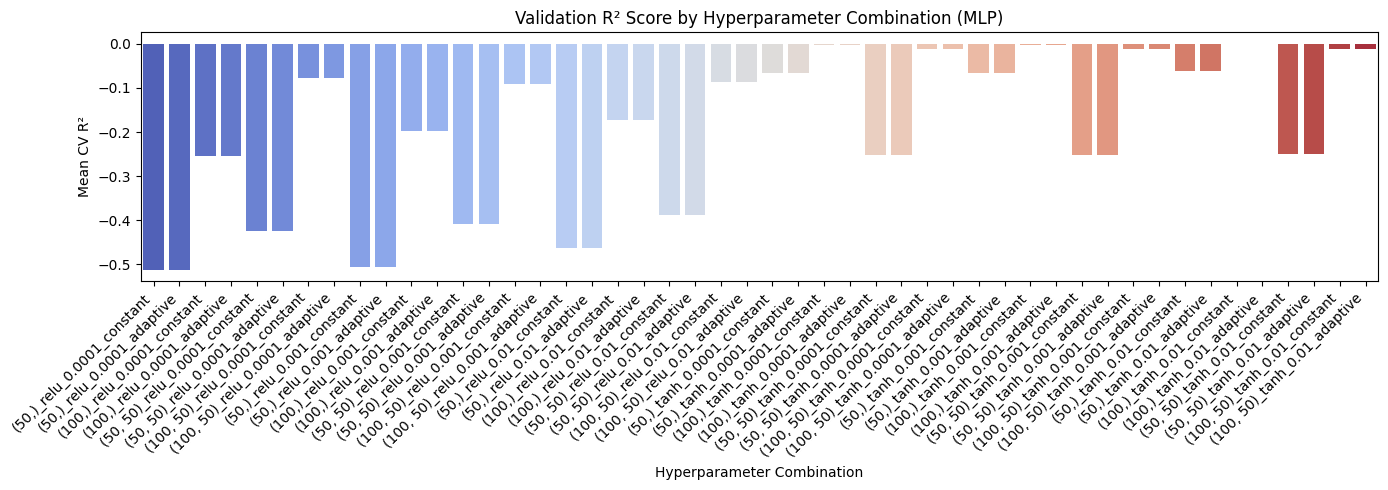

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)

X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- NaN 제거 ----------
valid_index = X_full.notna().all(axis=1) & y_full.notna()
X_full = X_full[valid_index]
y_full = y_full[valid_index]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# ---------- Baseline MLP ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=1000))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default MLP) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=1000))
])

param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [1e-4, 1e-3, 1e-2],
    'model__learning_rate': ['constant', 'adaptive']
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best MLP Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"{row['param_model__hidden_layer_sizes']}_{row['param_model__activation']}_{row['param_model__alpha']}_{row['param_model__learning_rate']}",
    axis=1
)

plt.figure(figsize=(14, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (MLP)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



🔍 Running: Lasso
Fitting 5 folds for each of 6 candidates, totalling 30 fits

🏆 Lasso Results:
R²    = 0.051
RMSE  = 2.428
MAE   = 2.006

✅ Best Params: {'model__alpha': np.float64(0.01)}

🔍 Running: LightGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10131
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 58
[LightGBM] [Info] Start training from score 5.505321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



🏆 KNN Results:
R²    = 0.388
RMSE  = 1.949
MAE   = 1.377

✅ Best Params: {'model__n_neighbors': 3, 'model__weights': 'distance'}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3474748873.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="R2", palette="Set2")


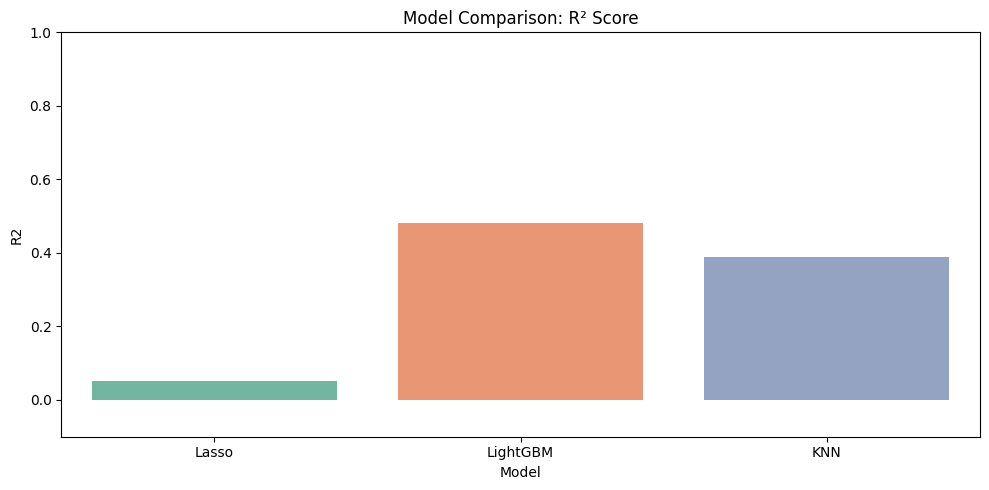

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3474748873.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", palette="Set2")


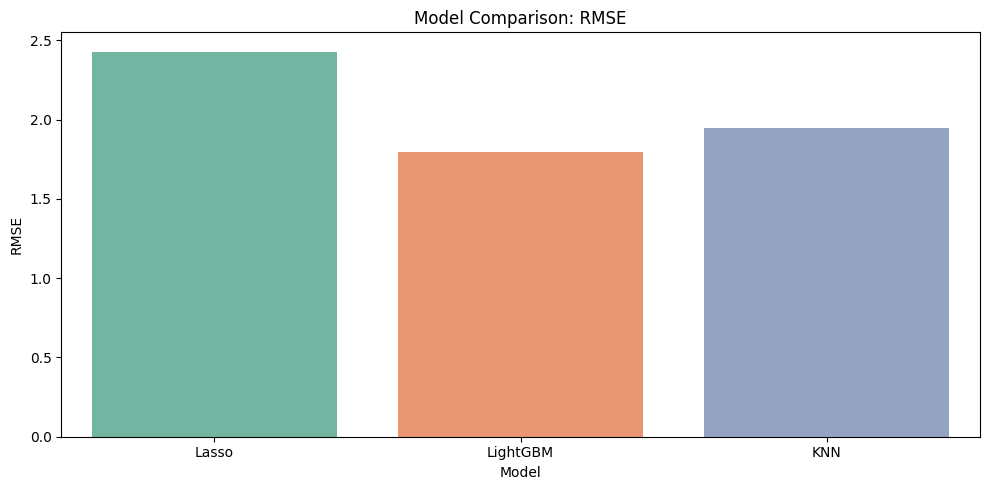

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3474748873.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAE", palette="Set2")


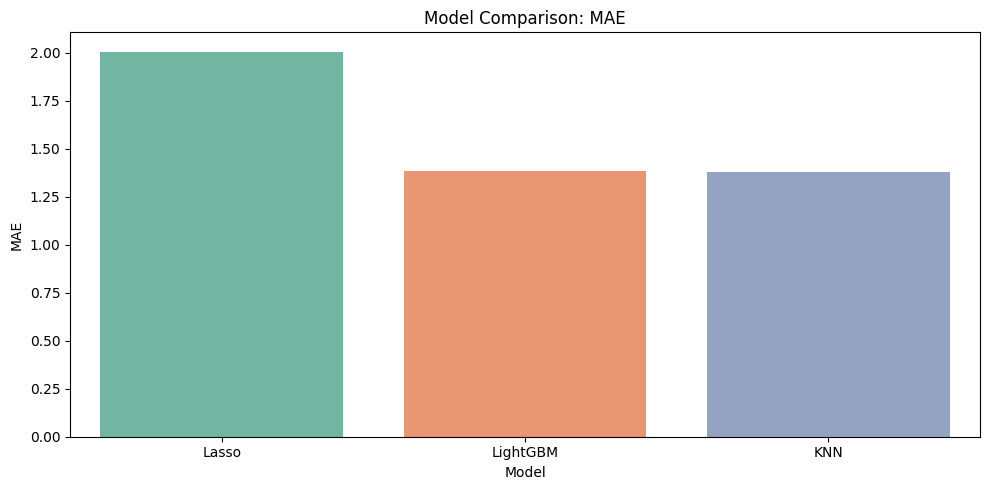

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
removed_participants = []

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    removed = []

    if pid in exclude_ppg_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'PPG' in col], errors='ignore')
        removed.append("PPG")
    if pid in exclude_rsp_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'RSP' in col], errors='ignore')
        removed.append("RSP")
    if pid in exclude_eda_ids:
        df_pid = df_pid.drop(columns=[col for col in df_pid.columns if 'EDA' in col], errors='ignore')
        removed.append("EDA")

    if removed:
        removed_participants.append((pid, removed))
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# ---------- 공통 실행 함수 ----------
results = []

def run_model(name, estimator, param_grid):
    print(f"\n🔍 Running: {name}")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        verbose=2,
        n_jobs=-1
    )
    grid.fit(X_trainval, y_trainval)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n🏆 {name} Results:")
    print(f"R²    = {r2:.3f}")
    print(f"RMSE  = {rmse:.3f}")
    print(f"MAE   = {mae:.3f}")
    print(f"\n✅ Best Params: {grid.best_params_}")

    results.append({
        'Model': name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Best Params': grid.best_params_
    })

# ---------- 1. Lasso ----------
run_model(
    "Lasso",
    Lasso(max_iter=5000),
    {'model__alpha': np.logspace(-4, 1, 6)}
)

# ---------- 2. LightGBM ----------
run_model(
    "LightGBM",
    LGBMRegressor(random_state=42),
    {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7]
    }
)

# ---------- 3. KNN ----------
run_model(
    "KNN",
    KNeighborsRegressor(),
    {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    }
)

# ---------- 결과 시각화 ----------
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="R2", palette="Set2")
plt.title("Model Comparison: R² Score")
plt.ylim(-0.1, 1.0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="Set2")
plt.title("Model Comparison: RMSE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="MAE", palette="Set2")
plt.title("Model Comparison: MAE")
plt.tight_layout()
plt.show()


In [29]:
results_df

Model        R2      RMSE       MAE  \
0     Lasso  0.050731  2.428338  2.005890   
1  LightGBM  0.482683  1.792638  1.385703   
2       KNN  0.388325  1.949282  1.377389   

                                         Best Params  
0                             {'model__alpha': 0.01}  
1  {'model__learning_rate': 0.1, 'model__max_dept...  
2  {'model__n_neighbors': 3, 'model__weights': 'd...

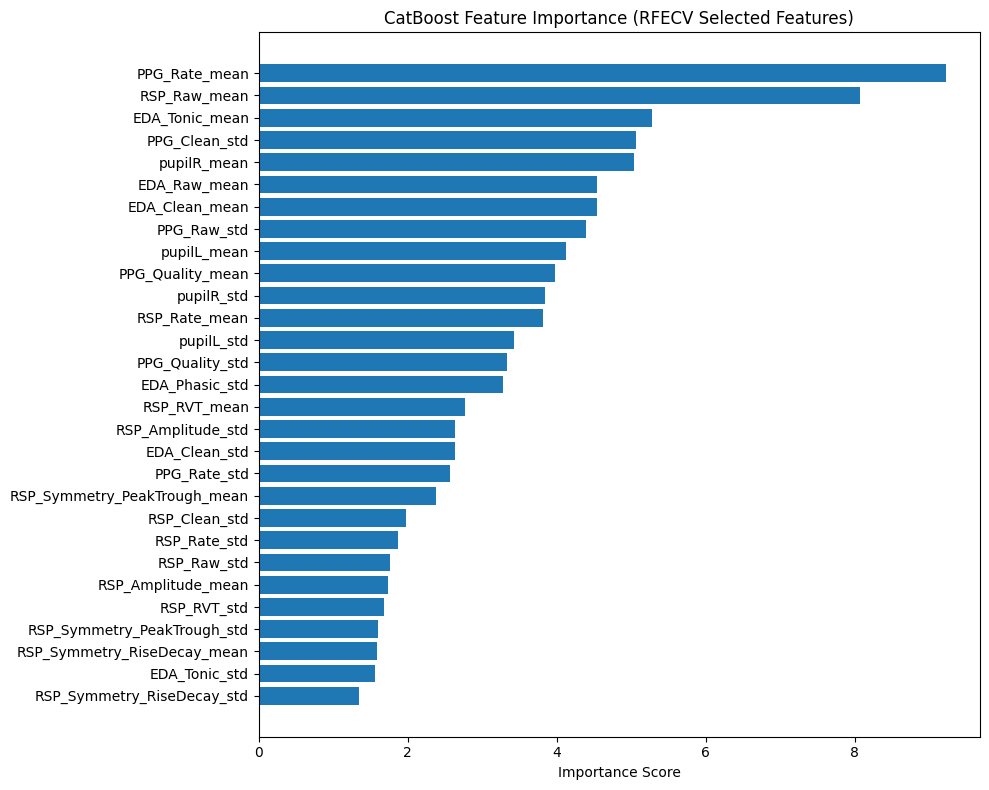

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

# --- Step 3에서 선택된 Feature 사용 ---
X_selected = X_full[selected_rfecv_features]
y_selected = y_full

# --- 모델 학습 ---
model_cb = CatBoostRegressor(verbose=0)
model_cb.fit(X_selected, y_selected)

# --- Feature Importance 추출 ---
feature_importances = model_cb.get_feature_importance()
feature_names = selected_rfecv_features

# --- DataFrame으로 정리 ---
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# --- 시각화 ---
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('CatBoost Feature Importance (RFECV Selected Features)')
plt.tight_layout()
plt.show()


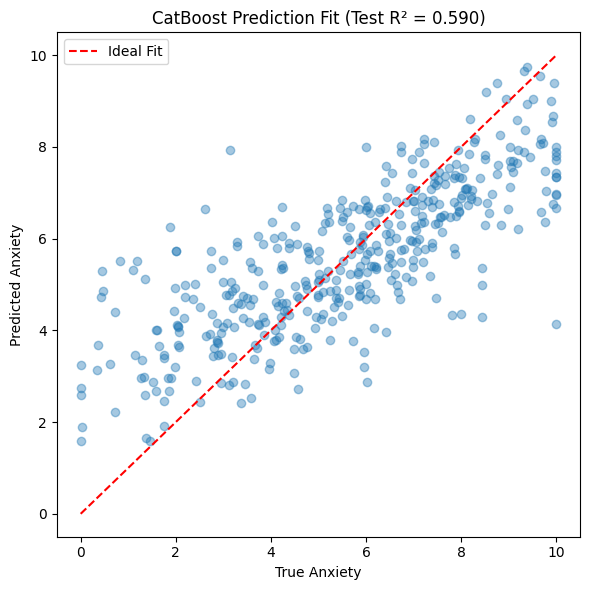

In [29]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- 데이터 분리 ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfecv)  # 선택된 feature 사용
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_full, test_size=0.2, random_state=42)

# --- 모델 학습 ---
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

# --- 예측 및 시각화 ---
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("True Anxiety")
plt.ylabel("Predicted Anxiety")
plt.title(f"CatBoost Prediction Fit (Test R² = {r2:.3f})")
plt.legend()
plt.tight_layout()
plt.show()


📊 MLP Regressor R² Score
Train: 0.356
Test:  0.104


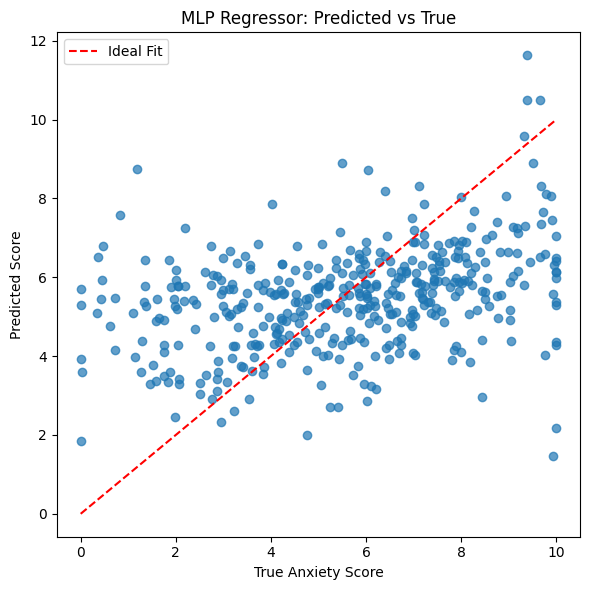

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 3: RFECV ----------
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

rfecv = RFECV(
    estimator=Ridge(),
    step=1,
    min_features_to_select=5,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfecv)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_full, test_size=0.2, random_state=42
)

# ---------- MLP Regressor ----------
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"📊 MLP Regressor R² Score")
print(f"Train: {r2_train:.3f}")
print(f"Test:  {r2_test:.3f}")

# ---------- 회귀선 시각화 ----------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_full.min(), y_full.max()], [y_full.min(), y_full.max()], 'r--', label='Ideal Fit')
plt.xlabel("True Anxiety Score")
plt.ylabel("Predicted Score")
plt.title("MLP Regressor: Predicted vs True")
plt.legend()
plt.tight_layout()
plt.show()


## full code

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# ---------- 유효한 feature 컬럼 필터링 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

# ---------- 참가자별 후반부 기준 90/10 split ----------
split_dfs = {"Train": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.9)
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Test"]).reset_index(drop=True)
X_train = pd.concat(split_dfs["Train"])[valid_feature_cols].reset_index(drop=True)
y_train = pd.concat(split_dfs["Train"])["anxiety_mean"].reset_index(drop=True)
X_test  = pd.concat(split_dfs["Test"])[valid_feature_cols].reset_index(drop=True)
y_test  = pd.concat(split_dfs["Test"])["anxiety_mean"].reset_index(drop=True)

# ---------- 모델 및 파라미터 설정 ----------
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'LinearSVR': LinearSVR(max_iter=10000, random_state=42),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'XGBoost': XGBRegressor(verbosity=0, random_state=42)
}

param_grids = {
    'RandomForest': [
        {
            'model__n_estimators': [100],
            'model__max_depth': [None],
            'model__min_samples_split': [2],
            'model__min_samples_leaf': [1]
        },
        {
            'model__n_estimators': [100, 300, 500],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    ],
    'SVR': [
        {
            'model__C': [1.0],
            'model__epsilon': [0.1],
            'model__kernel': ['rbf']
        },
        {
            'model__C': [0.1, 1, 10],
            'model__epsilon': [0.1, 0.2],
            'model__kernel': ['rbf', 'linear']
        }
    ],
    'LinearSVR': [
        {
            'model__C': [1.0],
            'model__loss': ['epsilon_insensitive']
        },
        {
            'model__C': [0.1, 1.0, 10],
            'model__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
        }
    ],
    'Ridge': [
        {
            'model__alpha': [1.0]
        },
        {
            'model__alpha': [0.1, 1.0, 10]
        }
    ],
    'Lasso': [
        {
            'model__alpha': [1.0]
        },
        {
            'model__alpha': [0.1, 1.0, 10]
        }
    ],
    'DecisionTree': [
        {
            'model__max_depth': [None],
            'model__min_samples_split': [2],
            'model__min_samples_leaf': [1]
        },
        {
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    ],
    'KNN': [
        {
            'model__n_neighbors': [5],
            'model__weights': ['uniform']
        },
        {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    ],
    'CatBoost': [
        {
            'model__iterations': [1000],
            'model__learning_rate': [0.03],
            'model__depth': [6],
            'model__l2_leaf_reg': [3]
        },
        {
            'model__iterations': [300, 500],
            'model__learning_rate': [0.03, 0.1, 0.3],
            'model__depth': [4, 6, 8],
            'model__l2_leaf_reg': [1, 3, 5]
        }
    ],
    'XGBoost': [
        {
            'model__n_estimators': [100],
            'model__learning_rate': [0.3],
            'model__max_depth': [6],
            'model__reg_lambda': [1]
        },
        {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.3],
            'model__max_depth': [3, 5, 7],
            'model__reg_lambda': [0.5, 1.0, 2.0]
        }
    ]
}


# ---------- 모델별 학습 및 결과 저장 ----------
results_list = []

for model_name, model in models.items():
    print(f"\n🚀 Running model: {model_name}")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid = GridSearchCV(pipe, param_grids[model_name], cv=7, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    
    # RFECV 조건부 수행
    estimator = best_pipe.named_steps['model']
    try:
        if hasattr(estimator, "coef_") or hasattr(estimator, "feature_importances_"):
            rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='r2', n_jobs=-1)
            rfecv.fit(X_train, y_train)
            selected_features = X_train.columns[rfecv.support_]
        else:
            selected_features = X_train.columns
    except:
        selected_features = X_train.columns

    # 최종 학습 및 예측
    best_pipe.fit(X_train[selected_features], y_train)
    y_train_pred = best_pipe.predict(X_train[selected_features])
    y_test_pred = best_pipe.predict(X_test[selected_features])

    results_list.append({
        'Model': model_name,
        'BestParams': grid.best_params_,
        'SelectedFeatures': list(selected_features),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': mean_squared_error(y_train, y_train_pred) ** 0.5,
        'Test_RMSE': mean_squared_error(y_test, y_test_pred) ** 0.5,
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    })

results_df = pd.DataFrame(results_list)
print("\n✅ 전체 결과 요약:")
print(results_df[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE']])



🚀 Running model: RandomForest

🚀 Running model: SVR

🚀 Running model: LinearSVR

🚀 Running model: Ridge

🚀 Running model: Lasso

🚀 Running model: DecisionTree

🚀 Running model: KNN

🚀 Running model: CatBoost

🚀 Running model: XGBoost

✅ 전체 결과 요약:
          Model   Test_R2  Test_RMSE  Test_MAE
0  RandomForest  0.125247   2.452728  1.969164
1           SVR -0.018133   2.646116  2.125911
2     LinearSVR -0.034594   2.667422  2.170553
3         Ridge -0.072184   2.715447  2.214516
4         Lasso -0.029605   2.660983  2.157276
5  DecisionTree -0.016407   2.643872  2.148627
6           KNN  0.087537   2.505039  1.957254
7      CatBoost  0.196824   2.350239  1.875551
8       XGBoost  0.144602   2.425441  1.942731


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


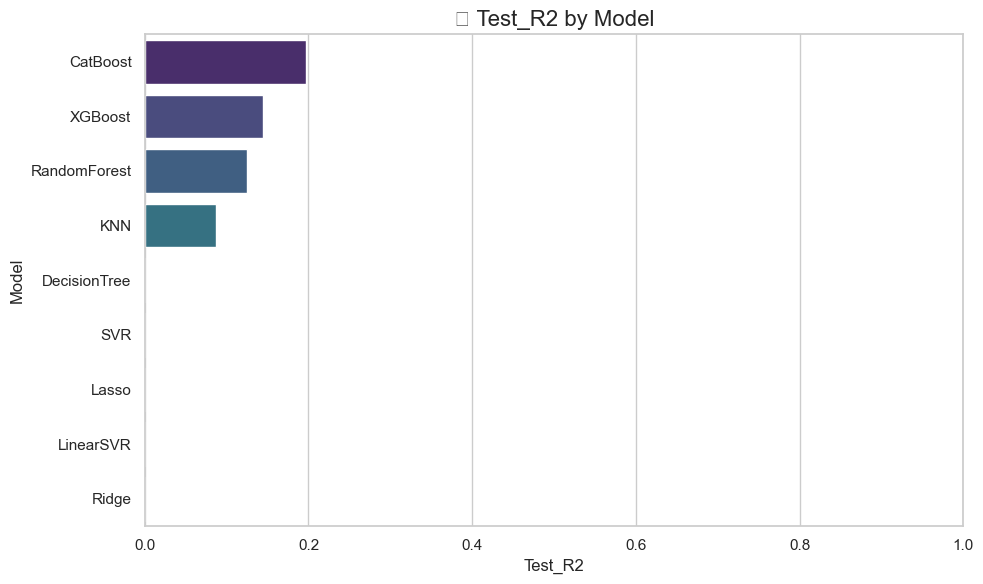

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


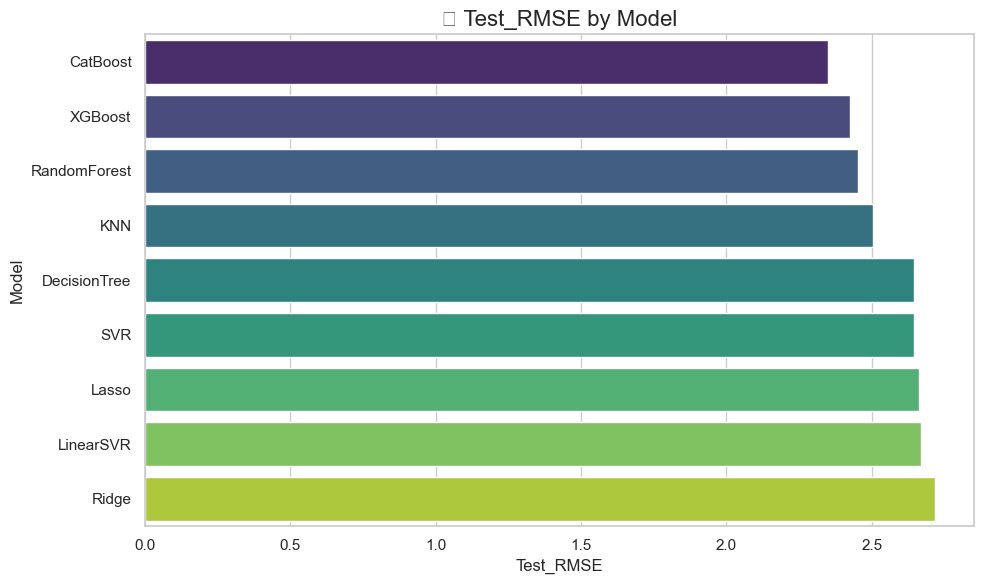

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


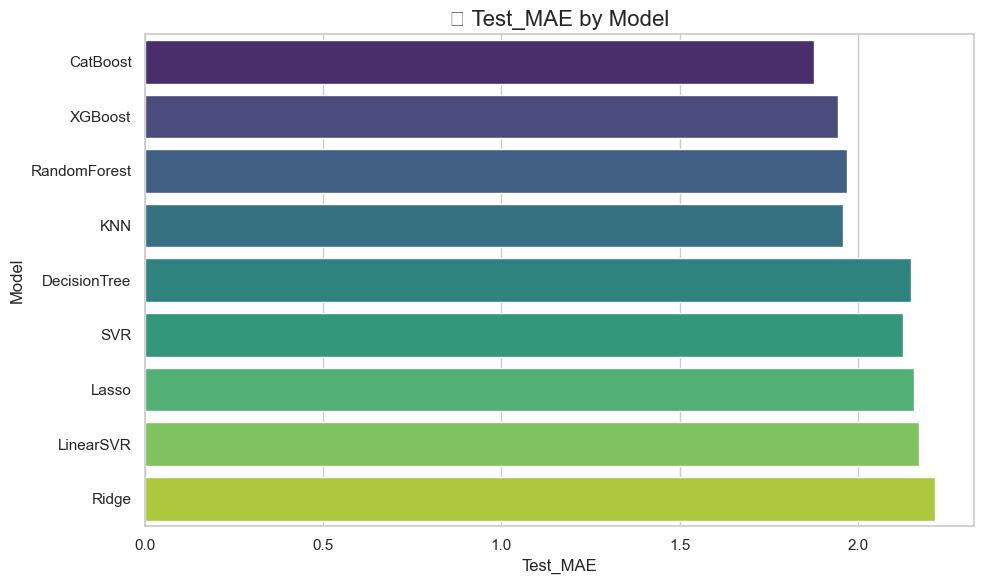

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 이름을 정렬된 순서로 보기 좋게 정렬
results_df_sorted = results_df.sort_values(by="Test_R2", ascending=False)

# 스타일 설정
sns.set(style="whitegrid")
metric_list = ["Test_R2", "Test_RMSE", "Test_MAE"]

# 3개 지표를 각각 시각화
for metric in metric_list:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
    plt.title(f"📊 {metric} by Model", fontsize=16)
    plt.xlabel(metric)
    plt.ylabel("Model")
    if metric == "Test_R2":
        plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from itertools import combinations

# === 설정 ===
target_model = RandomForestRegressor(**best_params, random_state=42)  # 이전에 튜닝된 best_params 사용
modalities = {
    "EDA": ["EDA_"],
    "PPG": ["PPG_"],
    "RSA": ["RSP_", "RSA_"],
    "Eye": ["eye_", "gaze_", "pupil", "valid"]
}

# === modality 조합 생성 ===
modality_names = list(modalities.keys())
modality_combos = []
for r in range(1, len(modality_names)+1):
    modality_combos += list(combinations(modality_names, r))

# === helper: column 추출 ===
def get_columns_for_modalities(combo, all_columns):
    matched_cols = []
    for modality in combo:
        for prefix in modalities[modality]:
            matched_cols += [col for col in all_columns if col.startswith(prefix)]
    return list(sorted(set(matched_cols)))

# === 결과 저장용 ===
results = []

for combo in modality_combos:
    selected_cols = get_columns_for_modalities(combo, X_full.columns)
    if len(selected_cols) < 2:
        continue

    X_train = pd.concat(split_dfs["Train"])[selected_cols]
    X_val = pd.concat(split_dfs["Val"])[selected_cols]
    X_test = pd.concat(split_dfs["Test"])[selected_cols]

    y_train = pd.concat(split_dfs["Train"])["anxiety_mean"]
    y_val = pd.concat(split_dfs["Val"])["anxiety_mean"]
    y_test = pd.concat(split_dfs["Test"])["anxiety_mean"]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Fit model
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(np.vstack([X_train_scaled, X_val_scaled]), np.hstack([y_train, y_val]))

    # Evaluate
    y_pred_train = model.predict(X_train_scaled)
    y_pred_val = model.predict(X_val_scaled)
    y_pred_test = model.predict(X_test_scaled)

    results.append({
        "Modality": "+".join(combo),
        "R2_Train": r2_score(y_train, y_pred_train),
        "R2_Val": r2_score(y_val, y_pred_val),
        "R2_Test": r2_score(y_test, y_pred_test),
        "RMSE_Test": mean_squared_error(y_test, y_pred_test, squared=False),
        "MAE_Test": mean_absolute_error(y_test, y_pred_test)
    })

# === 결과 DataFrame 출력 ===
result_df = pd.DataFrame(results)
print("📊 Best 모델 기반 modality 조합별 성능 요약:")
print(result_df.sort_values("R2_Test", ascending=False))

# === 라인 플롯 ===
plt.figure(figsize=(10, 6))
for metric in ["R2_Train", "R2_Val", "R2_Test"]:
    plt.plot(result_df["Modality"], result_df[metric], marker='o', label=metric)

plt.title("Modality 조합별 R2 Score (Train / Val / Test)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("R² Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
